In [1]:
import numpy as np
import pandas as pd
import random
import os
import re
import json
import whisper
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Bidirectional, Concatenate, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import average_precision_score, precision_recall_curve, hamming_loss, accuracy_score, f1_score, classification_report, multilabel_confusion_matrix, roc_auc_score

In [2]:
def set_seeds(seed=222):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seeds()

In [ ]:
# Models training is commented and replaced with the load_model() function in order to 
# save time everytime we reopened and runned these document

## Data Preprocessing

In [4]:
def load_prepare_imdb (directory):

    def load_imdb(directory):
        reviews = []
        labels = []
        for label in ['pos', 'neg']:
            path = f'{directory}/{label}'
            for file in os.listdir(path):
                with open(f'{path}/{file}', 'r', encoding='utf-8', errors='ignore') as f:
                    reviews.append(f.read())
                    labels.append(1 if label == 'pos' else 0)
        
        return reviews, labels

    X_temp, y_temp = load_imdb(directory + 'train')
    X_test, y_test = load_imdb(directory + 'test')

    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        return text

    X_temp = [preprocess_text(review) for review in X_temp]
    X_test = np.array([preprocess_text(review) for review in X_test])
    y_test = np.array(y_test)

    train = pd.DataFrame({'text': X_temp, 'label': y_temp})
    train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

    X_train = train_data['text'].to_numpy()
    y_train = train_data['label'].to_numpy()
    X_val = val_data['text'].to_numpy()
    y_val = val_data['label'].to_numpy()

    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test
    }

def load_prepare_goemotions (directory):

    emo1_df = 'goemotions_1.csv'
    emo2_df = 'goemotions_2.csv'
    emo3_df = 'goemotions_3.csv'
    emo1 = pd.read_csv(f"{directory}{emo1_df}", sep=',')
    emo2 = pd.read_csv(f"{directory}{emo2_df}", sep=',')
    emo3 = pd.read_csv(f"{directory}{emo3_df}", sep=',')

    emotions_df = pd.concat([emo1, emo2, emo3], axis=0, ignore_index=True)

    emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
    ]
    
    X = emotions_df['text'].values
    y_multi = emotions_df[emotion_columns].values

    X_temp, X_test, y_temp, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'emotion_columns': emotion_columns
    }

In [5]:
datadir_imdb = "aclImdb/"
datadir_emotions = "goemotions/data/full_dataset/"

sentiment_data = load_prepare_imdb(datadir_imdb)
emotion_data = load_prepare_goemotions(datadir_emotions)

In [ ]:
## Tokenizer 

train_texts = np.concatenate((sentiment_data['X_train'], emotion_data['X_train']))
max_words = 30000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

In [8]:
def preprocess_text_data(texts, tokenizer, max_len):

    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    
    return padded_sequences

In [6]:
# Save the tokenizer for future preprocessing
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

In [ ]:
# with open('tokenizer.json', 'r', encoding='utf-8') as f:
#         tokenizer = tokenizer_from_json(f.read())

In [9]:
max_length = 500

sentiment_data['X_train'] = preprocess_text_data(sentiment_data['X_train'], tokenizer, max_length)
sentiment_data['X_val'] = preprocess_text_data(sentiment_data['X_val'], tokenizer, max_length)  
sentiment_data['X_test'] = preprocess_text_data(sentiment_data['X_test'], tokenizer, max_length)

emotion_data['X_train'] = preprocess_text_data(emotion_data['X_train'], tokenizer, max_length)
emotion_data['X_val'] = preprocess_text_data(emotion_data['X_val'], tokenizer, max_length)
emotion_data['X_test'] = preprocess_text_data(emotion_data['X_test'], tokenizer, max_length)

In [10]:
# Verifying shapes across all dictionaries

print("Sentiment data\n")
for key, item in sentiment_data.items():
    print(key, item.shape)

print("\nEmotion data\n")
for key, item in emotion_data.items():
    if key != 'emotion_columns':
        print(key, item.shape)

Sentiment data

X_train (20000, 500)
y_train (20000,)
X_val (5000, 500)
y_val (5000,)
X_test (25000, 500)
y_test (25000,)

Emotion data

X_train (126735, 500)
y_train (126735, 28)
X_val (42245, 500)
y_val (42245, 28)
X_test (42245, 500)
y_test (42245, 28)


## Sentiment Models

### CNN Architecture

In [ ]:
# CNN_sentiment_model = Sequential([
    
#     layers.Embedding(input_dim=max_words, output_dim=100),

#     layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
#     layers.GlobalMaxPooling1D(),

#     layers.Dense(32, activation='relu'),
#     layers.Dropout(0.5),

#     # Final output layer
#     layers.Dense(1, activation='sigmoid')
# ])

# CNN_sentiment_model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.0005),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
# history = CNN_sentiment_model.fit(
#     sentiment_data['X_train'], sentiment_data['y_train'],
#     epochs=20,
#     batch_size=128,
#     validation_data = (sentiment_data['X_val'], sentiment_data['y_val']),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
# )

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5710 - loss: 0.6793 - val_accuracy: 0.7696 - val_loss: 0.5133
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7881 - loss: 0.4786 - val_accuracy: 0.8428 - val_loss: 0.3653
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8677 - loss: 0.3383 - val_accuracy: 0.8692 - val_loss: 0.3073
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9195 - loss: 0.2308 - val_accuracy: 0.8824 - val_loss: 0.2834
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9590 - loss: 0.1453 - val_accuracy: 0.8830 - val_loss: 0.2813
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9819 - loss: 0.0825 - val_accuracy: 0.8838 - val_loss: 0.2855
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9915 - loss: 0.0471 - val_accuracy: 0.8828 - val_loss: 0.3034
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9969 - loss: 0.0267 - val_accu

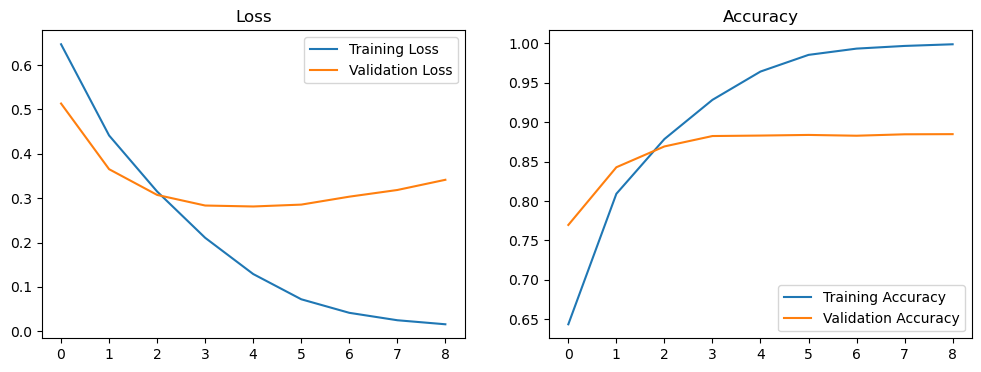

In [ ]:
# Plot training history
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy')
# plt.legend()
# plt.show()

In [9]:
# CNN_sentiment_model.save('models/CNN_sentiment_model.keras')
CNN_sentiment_model = load_model('models/CNN_sentiment_model.keras')

In [10]:
CNN_sentiment_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 100)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 498, 64)        │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,064,133 (34.58 MB)

 Trainable params: 3,021,377 (11.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,042,756 (23.05 MB)

In [11]:
results = CNN_sentiment_model.evaluate(sentiment_data['X_test'], sentiment_data['y_test'])

print(f"Test accuracy: {round(results[1]*100, 2)}%")
print(f"Test loss: {round(results[0], 4)}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8601 - loss: 0.3330
Test accuracy: 87.85%
Test loss: 0.2933


### LSTM Architecture

In [ ]:
# LSTM_sentiment_model = Sequential([
    
#     layers.Embedding(input_dim=max_words, output_dim=128),  
#     layers.SpatialDropout1D(0.2), 

#     layers.Bidirectional(GRU(32, dropout=0.3, recurrent_dropout=0.3)),  
#     layers.BatchNormalization(),

#     layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#     layers.Dropout(0.5),
    
#     layers.Dense(1, activation='sigmoid')
# ])

# LSTM_sentiment_model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
# history = LSTM_sentiment_model.fit(
#     sentiment_data['X_train'], sentiment_data['y_train'],
#     epochs=20,
#     batch_size=32,
#     validation_data = (sentiment_data['X_val'], sentiment_data['y_val']),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
# )

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1628s 3s/step - accuracy: 0.5693 - loss: 0.7652 - val_accuracy: 0.7172 - val_loss: 0.5978
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2267s 4s/step - accuracy: 0.7604 - loss: 0.5412 - val_accuracy: 0.7786 - val_loss: 0.4982
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1561s 2s/step - accuracy: 0.8534 - loss: 0.3771 - val_accuracy: 0.8166 - val_loss: 0.4663
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2171s 3s/step - accuracy: 0.9131 - loss: 0.2493 - val_accuracy: 0.8296 - val_loss: 0.4873
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2455s 4s/step - accuracy: 0.9503 - loss: 0.1518 - val_accuracy: 0.8284 - val_loss: 0.6514


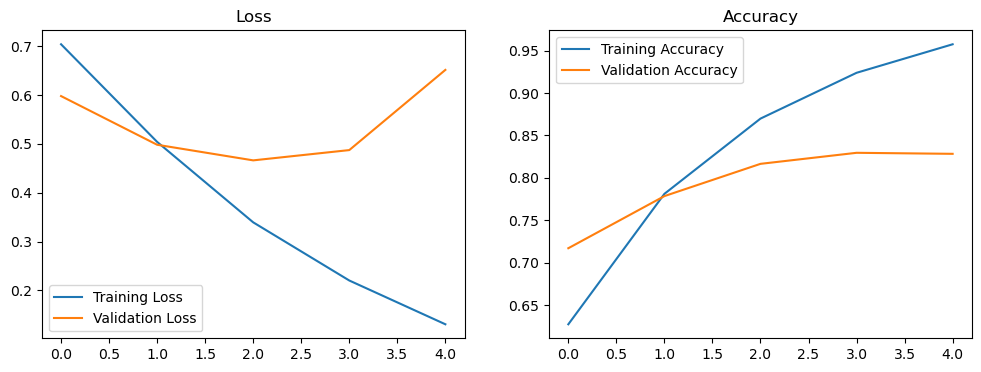

In [ ]:
# Plot training history
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy')
# plt.legend()
# plt.show()

In [12]:
# LSTM_sentiment_model.save('models/LSTM_sentiment_model.keras')
LSTM_sentiment_model = load_model('models/LSTM_sentiment_model.keras')

In [13]:
LSTM_sentiment_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (32, 800, 128)         │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (32, 800, 128)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (32, 64)               │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (32, 64)               │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (32, 128)              │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (32, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,639,173 (44.40 MB)

 Trainable params: 3,879,681 (14.80 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 7,759,364 (29.60 MB)

In [14]:
results = LSTM_sentiment_model.evaluate(sentiment_data['X_test'], sentiment_data['y_test'])

print(f"Test accuracy: {round(results[1]*100, 2)}%")
print(f"Test loss: {round(results[0], 4)}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 93ms/step - accuracy: 0.7987 - loss: 0.4979
Test accuracy: 78.44%
Test loss: 0.5445


### Fit GoEmotions Data into CNN model

In [15]:
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

In [16]:
positive_emotions = ['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief']
negative_emotions = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']
ambiguous_emotions = ['confusion', 'curiosity', 'realization', 'surprise', 'neutral']

positive_emotions_index = []
negative_emotions_index = []
ambiguous_emotions_index = []

j = 0
for i in emotion_data['emotion_columns']:
    if i in positive_emotions:
        positive_emotions_index.append(j)
    elif i in negative_emotions:
        negative_emotions_index.append(j)
    else :
        ambiguous_emotions_index.append(j)
    j += 1


In [17]:
print(positive_emotions_index) 
print(negative_emotions_index) 
print(ambiguous_emotions_index)

[0, 1, 4, 5, 8, 13, 15, 17, 18, 20, 21, 23]
[2, 3, 9, 10, 11, 12, 14, 16, 19, 24, 25]
[6, 7, 22, 26, 27]


In [18]:
def convert_emotions_to_sentiment(emotion_labels, positive_idx, ambiguous_idx):

    binary_labels = []
    
    for sample in emotion_labels:
        # Check if any positive emotion is present
        if any(sample[idx] == 1 for idx in positive_idx):
            binary_labels.append(1)
        # Check if any ambiguous emotion is present (and no positive)
        elif any(sample[idx] == 1 for idx in ambiguous_idx):
            binary_labels.append(2)
        # If neither positive nor ambiguous, then negative
        else:
            binary_labels.append(0)
            
    return np.array(binary_labels)

# Convert emotion labels to sentiment
binary_array_emotion_train = convert_emotions_to_sentiment(
    emotion_data['y_train'], 
    positive_emotions_index,
    ambiguous_emotions_index
)

# Verify results
print("Sample of original emotion labels:")
print(emotion_data['y_train'][:5])
print("\nConverted sentiment labels:")
print(binary_array_emotion_train[:5])
print(f"\nTotal samples: {len(binary_array_emotion_train)}")
print(f"Distribution: Positive={np.sum(binary_array_emotion_train == 1)}, "
      f"Ambiguous={np.sum(binary_array_emotion_train == 2)}, "
      f"Negative={np.sum(binary_array_emotion_train == 0)}")

Sample of original emotion labels:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

Converted sentiment labels:
[1 0 2 1 2]

Total samples: 126735
Distribution: Positive=49786, Ambiguous=47338, Negative=29611


In [19]:
# Convert emotion labels to sentiment - validation
binary_array_emotion_val = convert_emotions_to_sentiment(
    emotion_data['y_val'], 
    positive_emotions_index,
    ambiguous_emotions_index
)

# Verify results
print("Sample of original emotion labels:")
print(emotion_data['y_val'][:5])
print("\nConverted sentiment labels:")
print(binary_array_emotion_val[:5])
print(f"\nTotal samples: {len(binary_array_emotion_val)}")
print(f"Distribution: Positive={np.sum(binary_array_emotion_val == 1)}, "
      f"Ambiguous={np.sum(binary_array_emotion_val == 2)}, "
      f"Negative={np.sum(binary_array_emotion_val == 0)}")

Sample of original emotion labels:
[[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

Converted sentiment labels:
[0 1 2 1 2]

Total samples: 42245
Distribution: Positive=16622, Ambiguous=15703, Negative=9920


In [20]:
# Convert emotion labels to sentiment - test
binary_array_emotion_test = convert_emotions_to_sentiment(
    emotion_data['y_test'], 
    positive_emotions_index,
    ambiguous_emotions_index
)

# Verify results
print("Sample of original emotion labels:")
print(emotion_data['y_test'][:5])
print("\nConverted sentiment labels:")
print(binary_array_emotion_test[:5])
print(f"\nTotal samples: {len(binary_array_emotion_test)}")
print(f"Distribution: Positive={np.sum(binary_array_emotion_test == 1)}, "
      f"Ambiguous={np.sum(binary_array_emotion_test == 2)}, "
      f"Negative={np.sum(binary_array_emotion_test == 0)}")

Sample of original emotion labels:
[[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Converted sentiment labels:
[0 2 0 2 1]

Total samples: 42245
Distribution: Positive=16530, Ambiguous=15844, Negative=9871


In [21]:
# Filter emotion_data['X_train'] and binary_array_emotion_train to exclude samples with label 2 (ambiguous)
mask = binary_array_emotion_train != 2
X_train_filtered = emotion_data['X_train'][mask]
y_train_filtered = binary_array_emotion_train[mask]

print(f"Filtered X_train shape: {X_train_filtered.shape}")
print(f"Filtered y_train shape: {y_train_filtered.shape}")
print(f"Label distribution after filtering: {np.unique(y_train_filtered, return_counts=True)}")

Filtered X_train shape: (79397, 500)
Filtered y_train shape: (79397,)
Label distribution after filtering: (array([0, 1]), array([29611, 49786]))


In [22]:
# Filter emotion_data['X_train'] and binary_array_emotion_train to exclude samples with label 2 (ambiguous)
mask = binary_array_emotion_val != 2
X_val_filtered = emotion_data['X_val'][mask]
y_val_filtered = binary_array_emotion_val[mask]

print(f"Filtered X_train shape: {X_val_filtered.shape}")
print(f"Filtered y_train shape: {y_val_filtered.shape}")
print(f"Label distribution after filtering: {np.unique(y_val_filtered, return_counts=True)}")

Filtered X_train shape: (26542, 500)
Filtered y_train shape: (26542,)
Label distribution after filtering: (array([0, 1]), array([ 9920, 16622]))


In [23]:
# Filter emotion_data['X_train'] and binary_array_emotion_train to exclude samples with label 2 (ambiguous)
mask = binary_array_emotion_test != 2
X_test_filtered = emotion_data['X_test'][mask]
y_test_filtered = binary_array_emotion_test[mask]

print(f"Filtered X_train shape: {X_test_filtered.shape}")
print(f"Filtered y_train shape: {y_test_filtered.shape}")
print(f"Label distribution after filtering: {np.unique(y_test_filtered, return_counts=True)}")

Filtered X_train shape: (26401, 500)
Filtered y_train shape: (26401,)
Label distribution after filtering: (array([0, 1]), array([ 9871, 16530]))


In [24]:
# Results before finetuning to GoEmotions dataset
results_imdb = CNN_sentiment_model.evaluate(sentiment_data['X_test'], sentiment_data['y_test'])
results_goemotions = CNN_sentiment_model.evaluate(X_test_filtered, y_test_filtered)

print(f"Test accuracy on IMDB: {round(results_imdb[1]*100, 2)}%")
print(f"Test loss on IMDB: {round(results_imdb[0], 4)}")
print(f"Test accuracy on GoEmotions: {round(results_goemotions[1]*100, 2)}%")
print(f"Test loss on GoEmotions: {round(results_goemotions[0], 4)}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8601 - loss: 0.3330
826/826 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6128 - loss: 0.7776
Test accuracy on IMDB: 87.85%
Test loss on IMDB: 0.2933
Test accuracy on GoEmotions: 61.86%
Test loss on GoEmotions: 0.77


In [ ]:
# new_history = CNN_sentiment_model.fit(
#     X_train_filtered, y_train_filtered,
#     epochs=5,
#     batch_size=128,
#     validation_data = (X_val_filtered, y_val_filtered),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
# )

Epoch 1/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.7547 - loss: 0.5077 - val_accuracy: 0.8156 - val_loss: 0.4063
Epoch 2/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.8494 - loss: 0.3588 - val_accuracy: 0.8211 - val_loss: 0.4004
Epoch 3/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.8731 - loss: 0.3087 - val_accuracy: 0.8186 - val_loss: 0.4163
Epoch 4/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.8856 - loss: 0.2766 - val_accuracy: 0.8145 - val_loss: 0.4321
Epoch 5/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.8918 - loss: 0.2507 - val_accuracy: 0.8134 - val_loss: 0.4595


In [25]:
# CNN_sentiment_model.save('models/CNN_sentiment_model_imdb&goemotions.keras')
CNN_sentiment_model = load_model('models/CNN_sentiment_model_imdb&goemotions.keras')

In [26]:
results_imdb = CNN_sentiment_model.evaluate(sentiment_data['X_test'], sentiment_data['y_test'])
results_goemotions = CNN_sentiment_model.evaluate(X_test_filtered, y_test_filtered)

print(f"Test accuracy on IMDB: {round(results_imdb[1]*100, 2)}%")
print(f"Test loss on IMDB: {round(results_imdb[0], 4)}")
print(f"Test accuracy on GoEmotions: {round(results_goemotions[1]*100, 2)}%")
print(f"Test loss on GoEmotions: {round(results_goemotions[0], 4)}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8996 - loss: 0.2789
826/826 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8220 - loss: 0.3989
Test accuracy on IMDB: 80.26%
Test loss on IMDB: 0.4236
Test accuracy on GoEmotions: 81.82%
Test loss on GoEmotions: 0.4043


## Multi Class Emotion Models

#### Class Weights

In [11]:
class_counts = np.sum(emotion_data['y_train'], axis=0)
total_samples = len(emotion_data['y_train'])
class_weights = {}
for i in range(len(emotion_data['emotion_columns'])):
    weight = total_samples / (len(emotion_data['emotion_columns']) * class_counts[i])
    class_weights[i] = min(weight, np.float64(10.0))

In [12]:
class_weights

{0: np.float64(0.4457602915107347),
 1: np.float64(0.8201213988041312),
 2: np.float64(0.9439520333680917),
 3: np.float64(0.5527906692721055),
 4: np.float64(0.42309310151430174),
 5: np.float64(1.2309627413652433),
 6: np.float64(1.024502037120869),
 7: np.float64(0.7766386410432395),
 8: np.float64(2.000994694960212),
 9: np.float64(0.8929275991319787),
 10: np.float64(0.662701317715959),
 11: np.float64(1.4341730038022813),
 12: np.float64(3.100171232876712),
 13: np.float64(1.318069306930693),
 14: np.float64(2.35252079002079),
 15: np.float64(0.6466071428571428),
 16: np.float64(10.0),
 17: np.float64(0.942576009995835),
 18: np.float64(0.9269404054884293),
 19: np.float64(4.15633608815427),
 20: np.float64(0.8736247828604516),
 21: np.float64(5.963438735177865),
 22: np.float64(0.8624714176829268),
 23: np.float64(5.802884615384615),
 24: np.float64(2.9817193675889326),
 25: np.float64(1.0996720116618075),
 26: np.float64(1.351926523297491),
 27: np.float64(0.13657966203983102)}

#### Model Definition and training

In [ ]:
# # Define parameters
# vocab_size = 30000
# embedding_dim = 100
# rnn_units = 100
# dropout_rate = 0.5
# learning_rate = 0.001  

# emotion_model = Sequential([
#     layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),

#     layers.Bidirectional(layers.GRU(rnn_units, return_sequences=True)),
#     layers.GlobalAveragePooling1D(),
#     layers.Dropout(dropout_rate),
#     layers.Dense(64, activation="relu"),
#     layers.Dropout(dropout_rate),

#     layers.Dense(len(emotion_data['emotion_columns']), activation='sigmoid')
# ])

# # Compile model
# optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# emotion_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.F1Score(average='macro', threshold=0.5)])

In [ ]:
# history = emotion_model.fit(
#     emotion_data['X_train'], emotion_data['y_train'],
#     epochs=30,
#     batch_size=256,
#     validation_data=(emotion_data['X_val'],emotion_data['y_val']),
#     callbacks=[
#         EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
#         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8)
#     ],
#     verbose=1
# )

Epoch 1/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2267s 5s/step - auc: 0.5958 - f1_score: 0.0354 - loss: 0.2679 - val_auc: 0.7311 - val_f1_score: 0.0000e+00 - val_loss: 0.1576 - learning_rate: 0.0010
Epoch 2/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2367s 5s/step - auc: 0.6887 - f1_score: 0.0000e+00 - loss: 0.1667 - val_auc: 0.7344 - val_f1_score: 0.0000e+00 - val_loss: 0.1574 - learning_rate: 0.0010
Epoch 3/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2733s 6s/step - auc: 0.7080 - f1_score: 0.0065 - loss: 0.1622 - val_auc: 0.7958 - val_f1_score: 0.0461 - val_loss: 0.1448 - learning_rate: 0.0010
Epoch 4/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 3080s 6s/step - auc: 0.7726 - f1_score: 0.0419 - loss: 0.1499 - val_auc: 0.8255 - val_f1_score: 0.0545 - val_loss: 0.1378 - learning_rate: 0.0010
Epoch 5/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 3119s 6s/step - auc: 0.8083 - f1_score: 0.0632 - loss: 0.1423 - val_auc: 0.8458 - val_f1_score: 0.0921 - val_loss: 0.1330 - learning_rate: 0.0010
Epoch 6/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 3013s 6s/step - au

In [16]:
# emotion_model.save("models/emotion_model.keras")
emotion_model = load_model("models/emotion_model.keras")

In [17]:
emotion_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 100)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 500, 200)       │       121,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,407,654 (35.89 MB)

 Trainable params: 3,135,884 (11.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,271,770 (23.92 MB)

In [18]:
test_results = emotion_model.evaluate(emotion_data['X_test'], emotion_data['y_test'], verbose=1)

# Extract loss and accuracy 
test_loss = test_results[0]
test_auc = test_results[1]
test_f1score = test_results[2]

y_pred = emotion_model.predict(emotion_data['X_test'])
macro_ap = average_precision_score(emotion_data['y_test'], y_pred, average='macro')
micro_ap = average_precision_score(emotion_data['y_test'], y_pred, average='micro')

# 4. Print all results
print(f"Test loss: {test_loss:.4f}")
print(f"Test F1 Score: {test_f1score:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Macro average precision: {macro_ap:.4f}")
print(f"Micro average precision: {micro_ap:.4f}")

1321/1321 ━━━━━━━━━━━━━━━━━━━━ 154s 113ms/step - auc: 0.8607 - f1_score: 0.1037 - loss: 0.1294
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 150s 113ms/step
Test loss: 0.1291
Test F1 Score: 0.1049
Test AUC: 0.8607
Macro average precision: 0.2161
Micro average precision: 0.3524



Multi-label Classification Report:
                precision    recall  f1-score   support

    admiration       0.54      0.49      0.52      3456
     amusement       0.54      0.68      0.60      1891
         anger       0.34      0.15      0.21      1628
     annoyance       0.25      0.01      0.02      2722
      approval       0.00      0.00      0.00      3418
        caring       0.00      0.00      0.00      1147
     confusion       0.00      0.00      0.00      1463
     curiosity       0.00      0.00      0.00      1941
        desire       0.00      0.00      0.00       758
disappointment       0.00      0.00      0.00      1671
   disapproval       0.00      0.00      0.00      2289
       disgust       0.84      0.01      0.03      1074
 embarrassment       0.00      0.00      0.00       502
    excitement       0.00      0.00      0.00      1121
          fear       0.00      0.00      0.00       625
     gratitude       0.83      0.77      0.80      2330
         gr

c:\Users\35196\anaconda3\envs\UCP_APA_2425\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35196\anaconda3\envs\UCP_APA_2425\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35196\anaconda3\envs\UCP_APA_2425\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

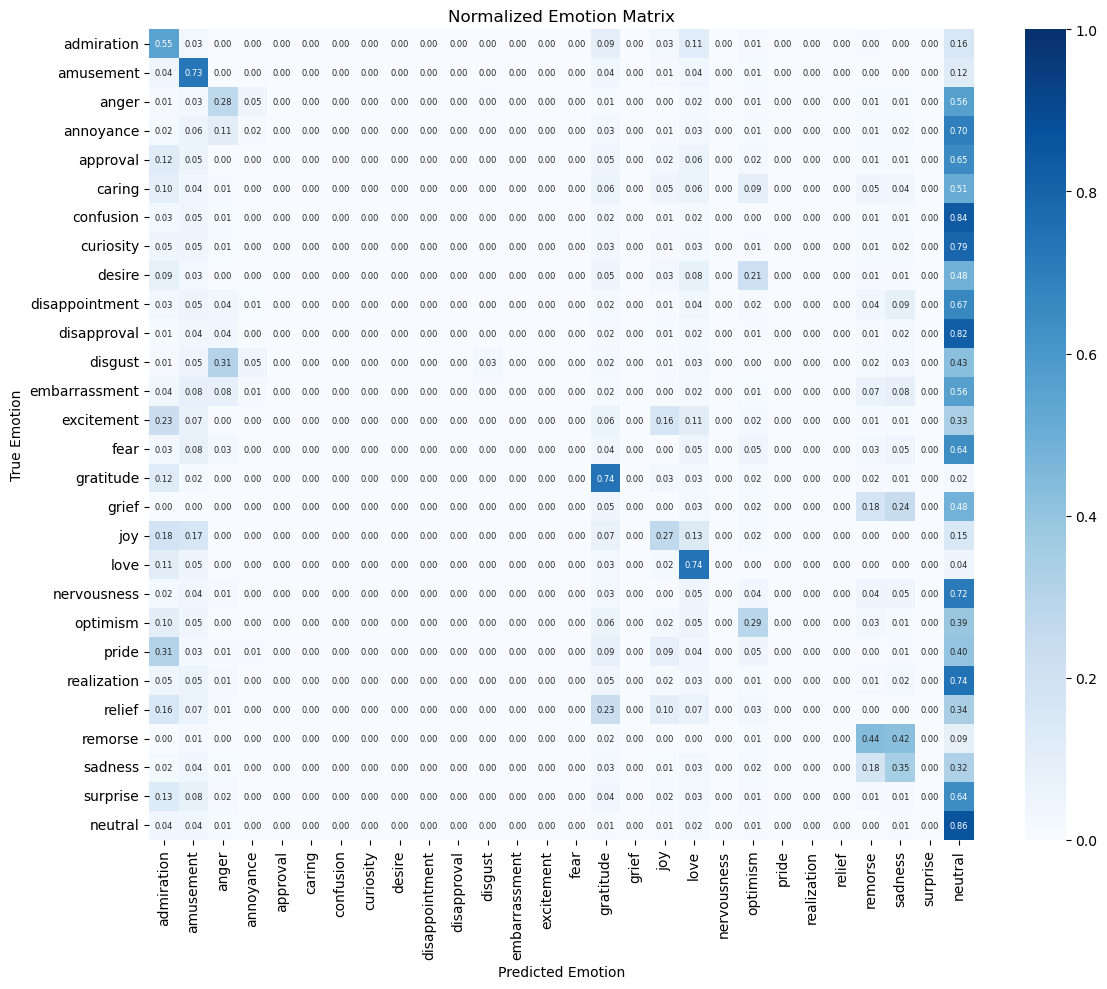

Hamming Loss: 0.04310315675566001
Subset Accuracy: 0.29137175997159426
Micro F1 Score: 0.3716958113054087
Macro F1 Score: 0.16694298142704164


In [23]:
# Using the same threshold for each class for now
threshold = 0.3

# Get multi-label predictions
y_pred_multilabel = (y_pred >= threshold).astype(int)
y_true_multilabel = emotion_data['y_test']  # Assuming this is already in multi-hot format

# Print multi-label classification report
print("\nMulti-label Classification Report:")
print(classification_report(y_true_multilabel, y_pred_multilabel,
                          target_names=emotion_data['emotion_columns']))

emotion_co_occurrence = np.dot(y_true_multilabel.T, y_pred_multilabel)

# Normalize co-occurrence matrix by row
row_sums = emotion_co_occurrence.sum(axis=1, keepdims=True)
row_sums = np.where(row_sums == 0, 1, row_sums)
emotion_co_occurrence_norm = emotion_co_occurrence / row_sums

plt.figure(figsize=(12, 10))
sns.heatmap(emotion_co_occurrence_norm, annot=True, fmt='.2f', cmap='Blues',
           xticklabels=emotion_data['emotion_columns'], 
           yticklabels=emotion_data['emotion_columns'],
           vmin=0, vmax=1,
           annot_kws={"size": 6}) 
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Normalized Emotion Matrix')
plt.tight_layout()
plt.show()


# Hamming loss (fraction of labels that are incorrectly predicted)
print(f"Hamming Loss: {hamming_loss(y_true_multilabel, y_pred_multilabel)}")

# Subset accuracy (exact match ratio)
print(f"Subset Accuracy: {accuracy_score(y_true_multilabel, y_pred_multilabel)}")

# Micro and macro F1 scores
print(f"Micro F1 Score: {f1_score(y_true_multilabel, y_pred_multilabel, average='micro')}")
print(f"Macro F1 Score: {f1_score(y_true_multilabel, y_pred_multilabel, average='macro')}")

#### Optimizing a threshold for each emotion

In [28]:
# Predict on validation set
y_pred_val = emotion_model.predict(emotion_data['X_val'])    
y_true_val = emotion_data['y_val']                               

# Compute per-class optimal thresholds: thresholds that maximize F1 score
optimal_thresholds = {}
for i, emo in enumerate(emotion_data['emotion_columns']):
    
    y_true_c = y_true_val[:, i]
    y_pred_c = y_pred_val[:, i]

    if y_true_c.sum() == 0:
        optimal_thresholds[emo] = 0.5
        continue

    precision, recall, thresholds = precision_recall_curve(y_true_c, y_pred_c)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.nanargmax(f1_scores[:-1])  

    optimal_thresholds[emo] = thresholds[best_idx]

print("Per-class optimal thresholds:")
for emo, thr in optimal_thresholds.items():
    print(f"  {emo:12s}: {thr:.3f}")

1321/1321 ━━━━━━━━━━━━━━━━━━━━ 240s 182ms/step
Per-class optimal thresholds:
  admiration  : 0.227
  amusement   : 0.242
  anger       : 0.201
  annoyance   : 0.156
  approval    : 0.111
  caring      : 0.060
  confusion   : 0.070
  curiosity   : 0.080
  desire      : 0.065
  disappointment: 0.096
  disapproval : 0.105
  disgust     : 0.154
  embarrassment: 0.062
  excitement  : 0.100
  fear        : 0.106
  gratitude   : 0.483
  grief       : 0.012
  joy         : 0.222
  love        : 0.294
  nervousness : 0.045
  optimism    : 0.145
  pride       : 0.033
  realization : 0.054
  relief      : 0.037
  remorse     : 0.176
  sadness     : 0.179
  surprise    : 0.078
  neutral     : 0.253


In [31]:
# Adjust some thresholds according to results on confusing matrix below
optimal_thresholds = {
    emotion: (
        threshold * 1.1 if emotion in ['approval', 'disappointment', 'disapproval', 'realization', 'neutral']
        else threshold
    )
    for emotion, threshold in optimal_thresholds.items()
}

optimal_thresholds

{'admiration': np.float32(0.22710174),
 'amusement': np.float32(0.24206203),
 'anger': np.float32(0.20056687),
 'annoyance': np.float32(0.15633032),
 'approval': np.float32(0.121963285),
 'caring': np.float32(0.059876267),
 'confusion': np.float32(0.070122115),
 'curiosity': np.float32(0.079814404),
 'desire': np.float32(0.06475216),
 'disappointment': np.float32(0.105809115),
 'disapproval': np.float32(0.11529606),
 'disgust': np.float32(0.15367132),
 'embarrassment': np.float32(0.061672095),
 'excitement': np.float32(0.1003704),
 'fear': np.float32(0.10625197),
 'gratitude': np.float32(0.48296863),
 'grief': np.float32(0.01160574),
 'joy': np.float32(0.2222823),
 'love': np.float32(0.2944189),
 'nervousness': np.float32(0.04527001),
 'optimism': np.float32(0.14463644),
 'pride': np.float32(0.032762423),
 'realization': np.float32(0.05934925),
 'relief': np.float32(0.037070915),
 'remorse': np.float32(0.17645746),
 'sadness': np.float32(0.17902139),
 'surprise': np.float32(0.07835497)

1321/1321 ━━━━━━━━━━━━━━━━━━━━ 233s 176ms/step

Multi-label Classification Report:
                precision    recall  f1-score   support

    admiration       0.48      0.58      0.53      3456
     amusement       0.53      0.72      0.61      1891
         anger       0.23      0.42      0.30      1628
     annoyance       0.19      0.44      0.26      2722
      approval       0.13      0.36      0.19      3418
        caring       0.09      0.22      0.13      1147
     confusion       0.08      0.26      0.13      1463
     curiosity       0.10      0.26      0.15      1941
        desire       0.17      0.29      0.22       758
disappointment       0.14      0.25      0.18      1671
   disapproval       0.12      0.43      0.18      2289
       disgust       0.20      0.27      0.23      1074
 embarrassment       0.13      0.16      0.14       502
    excitement       0.15      0.27      0.20      1121
          fear       0.29      0.28      0.28       625
     gratitude      

c:\Users\35196\anaconda3\envs\UCP_APA_2425\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


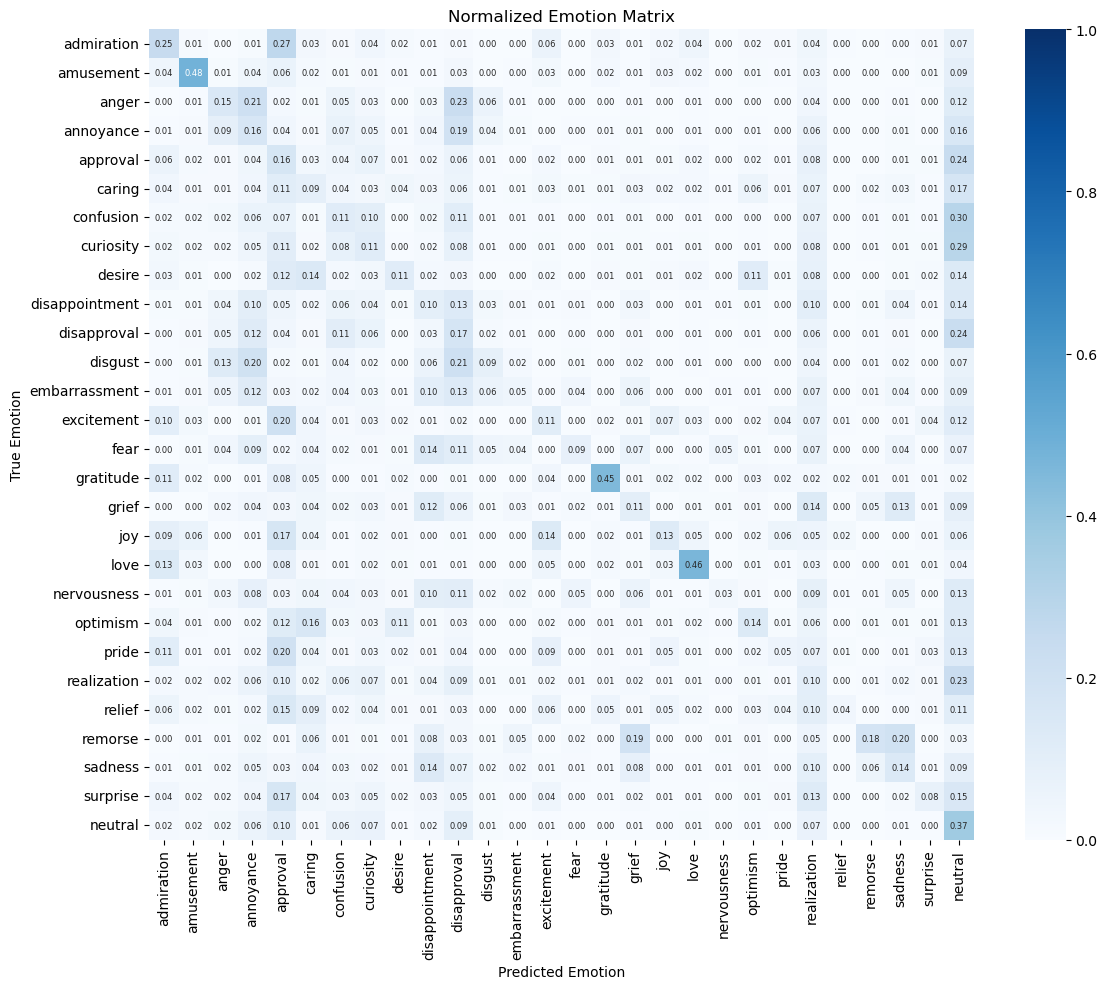

Hamming Loss: 0.08145342644099894
Subset Accuracy: 0.1745768730027222
Micro F1 Score: 0.33012584300910797
Macro F1 Score: 0.28211691945785117


In [32]:
y_pred = emotion_model.predict(emotion_data['X_test'])

y_pred_multilabel = np.zeros_like(y_pred)
for i, emo in enumerate(emotion_data['emotion_columns']):
    y_pred_multilabel[:, i] = (y_pred[:, i] >= optimal_thresholds[emo]).astype(int)
zero_rows = np.sum(y_pred_multilabel, axis=1) == 0
if np.any(zero_rows):
    max_indices = np.argmax(y_pred[zero_rows], axis=1)
    y_pred_multilabel[zero_rows, max_indices] = 1

y_true_multilabel = emotion_data['y_test']  

print("\nMulti-label Classification Report:")
print(classification_report(y_true_multilabel, y_pred_multilabel,
                          target_names=emotion_data['emotion_columns']))

emotion_co_occurrence = np.dot(y_true_multilabel.T, y_pred_multilabel)

row_sums = emotion_co_occurrence.sum(axis=1, keepdims=True)
row_sums = np.where(row_sums == 0, 1, row_sums)
emotion_co_occurrence_norm = emotion_co_occurrence / row_sums

plt.figure(figsize=(12, 10))
sns.heatmap(emotion_co_occurrence_norm, annot=True, fmt='.2f', cmap='Blues',
           xticklabels=emotion_data['emotion_columns'], 
           yticklabels=emotion_data['emotion_columns'],
           vmin=0, vmax=1,
           annot_kws={"size": 6}) 
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Normalized Emotion Matrix')
plt.tight_layout()
plt.show()

print(f"Hamming Loss: {hamming_loss(y_true_multilabel, y_pred_multilabel)}")                    # fraction of labels that are incorrectly predicted
print(f"Subset Accuracy: {accuracy_score(y_true_multilabel, y_pred_multilabel)}")               # proportion of samples where ALL emotions were predicted perfectly
print(f"Micro F1 Score: {f1_score(y_true_multilabel, y_pred_multilabel, average='micro')}")     # Treats each emotion-sample pair as a separate prediction
print(f"Macro F1 Score: {f1_score(y_true_multilabel, y_pred_multilabel, average='macro')}")     # Average of F1 scores computed for each emotion separately

In [33]:
# Save optimal thresholds to a JSON file
optimal_thresholds = {
    emotion: float(threshold) 
    for emotion, threshold in optimal_thresholds.items()
}

# Save optimal thresholds to JSON file
with open('optimal_thresholds.json', 'w') as f:
    json.dump(optimal_thresholds, f, indent=4)

In [ ]:
# Load thresholds from JSON file
# with open('optimal_thresholds.json') as f:
#     optimal_thresholds = json.load(f)

## Multitasking Architectures

### Transformer Multitasking Model

In [34]:
# Adjust sentiment labels to transformer
y_train_2 = np.array([(i, 1-i) for i in sentiment_data['y_train']])
y_val_2 = np.array([(i, 1-i) for i in sentiment_data['y_val']])
y_test_2 = np.array([(i, 1-i) for i in sentiment_data['y_test']])

In [ ]:
# def get_positional_encoding(seq_length, d_model):

#     positions = np.arange(seq_length)[:, np.newaxis]
#     depths = np.arange(d_model)[np.newaxis, :] // 2 * 2  

#     angle_rates = 1 / np.power(10000, (2 * (depths // 2)) / np.float32(d_model))
#     angle_rads = positions * angle_rates

#     pos_encoding = np.zeros(angle_rads.shape)
#     pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
#     pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
#     return tf.cast(pos_encoding, dtype=tf.float32)

# def create_transformer_model():
    
#     inputs = layers.Input(shape=(max_length,))
    
#     # Shared Embedding Layer 
#     embedding_dim = 128
#     embedding_layer = layers.Embedding(max_words, embedding_dim, mask_zero=True)(inputs)
    
#     # Embedding layer for positional encoding
#     pos_encoding = get_positional_encoding(max_length, embedding_dim)
#     pos_encoding = tf.keras.backend.constant(pos_encoding)
#     embedded_with_pos = embedding_layer + tf.expand_dims(pos_encoding, axis=0)
    
#     # Transformer block
#     transformer_block = layers.MultiHeadAttention(
#         num_heads=4, key_dim=32
#     )(embedded_with_pos, embedded_with_pos)
    
#     norm_transformer_block = layers.LayerNormalization(epsilon=1e-6)(transformer_block + embedded_with_pos)
    
#     # Feed Forward Shared Network 
#     ffn = layers.Dense(128, activation='relu')(norm_transformer_block)

#     # Feed Forward - Sentiment Branch
#     ffn_s = layers.Dense(128)(ffn)
#     ffn_s = layers.Dropout(0.1)(ffn_s)
#     ffn_output_s = layers.LayerNormalization(epsilon=1e-6)(norm_transformer_block + ffn_s)
#     pooled_s = layers.GlobalAveragePooling1D()(ffn_output_s)
#     dropout_s = layers.Dropout(0.1)(pooled_s)
#     sentiment_output = layers.Dense(2, activation='softmax', name='sentiment_output')(dropout_s)

#     # Feed Forward - Emotion Branch
#     ffn_e = layers.Dense(128)(ffn)
#     ffn_e = layers.Dropout(0.5)(ffn_e)
#     ffn_e = layers.Dense(128)(ffn_e)
#     ffn_e = layers.Dropout(0.5)(ffn_e)
#     ffn_e = layers.Dense(128)(ffn_e)
#     ffn_e = layers.Dropout(0.5)(ffn_e)
#     ffn_output_e = layers.LayerNormalization(epsilon=1e-6)(norm_transformer_block + ffn_e)
#     pooled_e = layers.GlobalAveragePooling1D()(ffn_output_e)
#     dropout_e = layers.Dropout(0.5)(pooled_e)
#     emotion_output = layers.Dense(28, activation='sigmoid', name='emotion_output')(dropout_e)
    
#     model = Model(inputs=inputs, outputs=[sentiment_output, emotion_output])
#     return model

# # Create and compile the model
# transformer_multitask_model = create_transformer_model()
# transformer_multitask_model.compile(
#     optimizer=keras.optimizers.Adam(1e-4),
#     loss={
#         'sentiment_output': 'binary_crossentropy',
#         'emotion_output': 'binary_crossentropy'
#     },
#     metrics={
#         'sentiment_output': 'accuracy',
#         'emotion_output': (tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall())
#     }
# )

In [ ]:
# transformer_multitask_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 500, 128)  │  3,840,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 500, 128)  │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 128)  │     66,048 │ add_4[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 500, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 128)  │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 500, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 500, 128)  │     16,512 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 500, 128)  │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 500, 128)  │     16,512 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 500, 128)  │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 500, 128)  │     16,512 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 500, 128)  │     16,512 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 500, 128)  │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 500, 128)  │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 500, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 500, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 128)  │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 128)  │        256 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 3,993,246 (15.23 MB)

 Trainable params: 3,993,246 (15.23 MB)

 Non-trainable params: 0 (0.00 B)

#### Training Transformer model with masking loss function

In [ ]:
# def train_multitask_model_with_masking(model, sentiment_data, emotion_data, epochs=20, batch_size=32):
    
#     # Define masked loss functions that ignore missing labels
#     def masked_binary_crossentropy(y_true, y_pred):
        
#         sample_has_label = tf.reduce_sum(y_true, axis=-1)
#         # Create a mask where samples have at least one valid label
#         mask = tf.cast(tf.not_equal(sample_has_label, 0), tf.float32)
#         mask = tf.expand_dims(mask, axis=-1)  # Add dimension to match y_true shape
        
#         # Apply standard binary crossentropy
#         loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
#         # Convert loss from per-class to per-sample by averaging
#         loss = tf.reduce_mean(loss, axis=-1, keepdims=True)
#         # Apply the mask
#         masked_loss = loss * mask
#         # Normalize by number of valid samples
#         return tf.reduce_sum(masked_loss) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())
    
#     def masked_binary_crossentropy_multi(y_true, y_pred):
#         # For multi-label case (emotions)
#         # Sum across all classes for each sample to detect if the sample has any valid labels
#         sample_has_label = tf.reduce_sum(y_true, axis=-1)
#         # Create a mask where samples have at least one valid label
#         mask = tf.cast(tf.not_equal(sample_has_label, 0), tf.float32)
#         mask = tf.expand_dims(mask, axis=-1)  # Add dimension to match y_true shape
        
#         # Apply standard binary crossentropy
#         loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
#         # Convert loss from per-class to per-sample by averaging
#         loss = tf.reduce_mean(loss, axis=-1, keepdims=True)
#         # Apply the mask
#         masked_loss = loss * mask
#         # Normalize by number of valid samples
#         return tf.reduce_sum(masked_loss) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())
    
#     # Recompile with custom loss functions
#     model.compile(
#         optimizer=keras.optimizers.Adam(1e-4),
#         loss={
#             'sentiment_output': masked_binary_crossentropy,
#             'emotion_output': masked_binary_crossentropy_multi
#         },
#         metrics={
#             'sentiment_output': 'accuracy',
#             'emotion_output': [tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
#         }
#     )
    
#     # Combine the datasets
#     X_combined = np.concatenate([sentiment_data['X_train'], emotion_data['X_train']])
    
#     # Create dummy labels for missing tasks
#     sentiment_labels = np.concatenate([
#         y_train_2,
#         np.zeros((len(emotion_data['X_train']), 2))  # Zeros for emotion data samples
#     ])
    
#     emotion_labels = np.concatenate([
#         np.zeros((len(sentiment_data['X_train']), 28)),  # Zeros for sentiment data
#         emotion_data['y_train']
#     ])
    
#     # Combined validation data
#     X_val_combined = np.concatenate([sentiment_data['X_val'], emotion_data['X_val']])
    
#     val_sentiment_labels = np.concatenate([
#         y_val_2,
#         np.zeros((len(emotion_data['X_val']), 2))
#     ])
    
#     val_emotion_labels = np.concatenate([
#         np.zeros((len(sentiment_data['X_val']), 28)),
#         emotion_data['y_val']
#     ])
    
#     # Train the model on combined data
#     history = model.fit(
#         X_combined,
#         {
#             'sentiment_output': sentiment_labels,
#             'emotion_output': emotion_labels
#         },
#         batch_size=batch_size,
#         epochs=epochs,
#         validation_data=(
#             X_val_combined,
#             {
#                 'sentiment_output': val_sentiment_labels,
#                 'emotion_output': val_emotion_labels
#             }
#         ),
#         verbose=1,
#         shuffle=True
#     )
    
#     # Evaluate on individual tasks
#     print("\nEvaluating sentiment task:")
#     sent_results = model.evaluate(
#         sentiment_data['X_val'],
#         {
#             'sentiment_output': y_val_2,
#             'emotion_output': np.zeros((len(sentiment_data['X_val']), 28))
#         },
#         verbose=1
#     )
    
#     print("\nEvaluating emotion task:")
#     emo_results = model.evaluate(
#         emotion_data['X_val'],
#         {
#             'sentiment_output': np.zeros((len(emotion_data['X_val']), 2)),
#             'emotion_output': emotion_data['y_val']
#         },
#         verbose=1
#     )
    
#     return model, history

In [ ]:
# history = train_multitask_model_with_masking(transformer_multitask_model, sentiment_data, emotion_data)

Epoch 1/20
4586/4586 ━━━━━━━━━━━━━━━━━━━━ 1430s 311ms/step - emotion_output_auc_9: 0.6513 - emotion_output_loss: 0.1884 - emotion_output_precision_9: 0.0970 - emotion_output_recall_9: 0.0392 - loss: 0.3157 - sentiment_output_accuracy: 0.5603 - sentiment_output_loss: 0.1273 - val_emotion_output_auc_9: 0.5980 - val_emotion_output_loss: 0.2442 - val_emotion_output_precision_9: 0.0000e+00 - val_emotion_output_recall_9: 0.0000e+00 - val_loss: 0.3138 - val_sentiment_output_accuracy: 0.0730 - val_sentiment_output_loss: 0.0696
Epoch 2/20
4586/4586 ━━━━━━━━━━━━━━━━━━━━ 1422s 310ms/step - emotion_output_auc_9: 0.7433 - emotion_output_loss: 0.1398 - emotion_output_precision_9: 0.1748 - emotion_output_recall_9: 1.0399e-04 - loss: 0.2154 - sentiment_output_accuracy: 0.5277 - sentiment_output_loss: 0.0756 - val_emotion_output_auc_9: 0.6274 - val_emotion_output_loss: 0.2477 - val_emotion_output_precision_9: 0.0000e+00 - val_emotion_output_recall_9: 0.0000e+00 - val_loss: 0.2840 - val_sentiment_output

In [ ]:
# transformer_multitask_model.save('models/transformer_multitask_model.keras')

In [9]:
def masked_binary_crossentropy(y_true, y_pred):
    
    sample_has_label = tf.reduce_sum(y_true, axis=-1)
    mask = tf.cast(tf.not_equal(sample_has_label, 0), tf.float32)
    mask = tf.expand_dims(mask, axis=-1)  

    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    loss = tf.reduce_mean(loss, axis=-1, keepdims=True)
    masked_loss = loss * mask
    return tf.reduce_sum(masked_loss) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())

def masked_binary_crossentropy_multi(y_true, y_pred):

    sample_has_label = tf.reduce_sum(y_true, axis=-1)
    mask = tf.cast(tf.not_equal(sample_has_label, 0), tf.float32)
    mask = tf.expand_dims(mask, axis=-1)  

    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    loss = tf.reduce_mean(loss, axis=-1, keepdims=True)
    masked_loss = loss * mask
    return tf.reduce_sum(masked_loss) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())

custom_objects = {
    'masked_binary_crossentropy': masked_binary_crossentropy,
    'masked_binary_crossentropy_multi': masked_binary_crossentropy_multi
}

# Load the model with custom objects
transformer_multitask_model = load_model(
    'models/transformer_multitask_model.keras', 
    custom_objects=custom_objects
)

In [36]:
print("\nEvaluating sentiment task on test:")
sent_results = transformer_multitask_model.evaluate(
    sentiment_data['X_test'],
    {
        'sentiment_output': y_test_2,
        'emotion_output': np.zeros((len(sentiment_data['X_test']), 28))
    },
    verbose=1
)

print("\nEvaluating emotion task:")
emo_results = transformer_multitask_model.evaluate(
    emotion_data['X_test'],
    {
        'sentiment_output': np.zeros((len(emotion_data['X_test']), 2)),
        'emotion_output': emotion_data['y_test']
    },
    verbose=1
)


Evaluating sentiment task on test:
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 109ms/step - emotion_output_auc_9: 0.0000e+00 - emotion_output_loss: 0.0000e+00 - emotion_output_precision_9: 0.0000e+00 - emotion_output_recall_9: 0.0000e+00 - loss: 1.4270 - sentiment_output_accuracy: 0.8026 - sentiment_output_loss: 1.4270

Evaluating emotion task:
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 273s 205ms/step - emotion_output_auc_9: 0.8409 - emotion_output_loss: 0.1481 - emotion_output_precision_9: 0.5398 - emotion_output_recall_9: 0.2181 - loss: 0.1481 - sentiment_output_accuracy: 0.4077 - sentiment_output_loss: 0.0000e+00


In [37]:
print(f"Test accuracy for Sentiment (on IMDB data): {round(sent_results[6]*100, 2)}%")
print(f"Test accuracy for Sentiment (on Goemotions data): {round(emo_results[6]*100, 2)}%")
print(f"AUC for emotion: {round(emo_results[3]*100, 2)}%")
print(f"Precision for emotion: {round(emo_results[4]*100, 2)}%")
print(f"Recall for emotion: {round(emo_results[5]*100, 2)}%")
print(f"F1-score for emotion: {round(((2*emo_results[4]*emo_results[5])/(emo_results[4]+emo_results[5]))*100, 2)}%")

Test accuracy for Sentiment (on IMDB data): 80.28%
Test accuracy for Sentiment (on Goemotions data): 41.07%
AUC for emotion: 84.1%
Precision for emotion: 53.87%
Recall for emotion: 21.69%
F1-score for emotion: 30.92%


In [41]:
## Optimal thresholds for transformer model
y_pred_val = transformer_multitask_model.predict(emotion_data['X_val'])[1]
y_true_val = emotion_data['y_val']                               

# Compute per-class optimal thresholds: thresholds that maximize F1 score
optimal_thresholds_transformer = {}
for i, emo in enumerate(emotion_data['emotion_columns']):
    
    y_true_c = y_true_val[:, i]
    y_pred_c = y_pred_val[:, i]

    if y_true_c.sum() == 0:
        optimal_thresholds[emo] = 0.5
        continue

    precision, recall, thresholds = precision_recall_curve(y_true_c, y_pred_c)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.nanargmax(f1_scores[:-1])  

    optimal_thresholds_transformer[emo] = thresholds[best_idx]

print("Per-class optimal thresholds:")
for emo, thr in optimal_thresholds_transformer .items():
    print(f"  {emo:12s}: {thr:.3f}")

1321/1321 ━━━━━━━━━━━━━━━━━━━━ 163s 123ms/step
Per-class optimal thresholds:
  admiration  : 0.358
  amusement   : 0.147
  anger       : 0.112
  annoyance   : 0.095
  approval    : 0.069
  caring      : 0.058
  confusion   : 0.056
  curiosity   : 0.079
  desire      : 0.092
  disappointment: 0.056
  disapproval : 0.089
  disgust     : 0.072
  embarrassment: 0.019
  excitement  : 0.073
  fear        : 0.114
  gratitude   : 0.419
  grief       : 0.006
  joy         : 0.135
  love        : 0.269
  nervousness : 0.023
  optimism    : 0.149
  pride       : 0.010
  realization : 0.034
  relief      : 0.003
  remorse     : 0.091
  sadness     : 0.134
  surprise    : 0.078
  neutral     : 0.225


1321/1321 ━━━━━━━━━━━━━━━━━━━━ 144s 109ms/step

Multi-label Classification Report:
                precision    recall  f1-score   support

    admiration       0.47      0.53      0.50      3456
     amusement       0.52      0.68      0.59      1891
         anger       0.25      0.41      0.31      1628
     annoyance       0.19      0.40      0.25      2722
      approval       0.13      0.41      0.19      3418
        caring       0.11      0.22      0.14      1147
     confusion       0.13      0.24      0.17      1463
     curiosity       0.16      0.24      0.19      1941
        desire       0.24      0.20      0.22       758
disappointment       0.12      0.23      0.16      1671
   disapproval       0.13      0.34      0.18      2289
       disgust       0.19      0.29      0.23      1074
 embarrassment       0.17      0.16      0.17       502
    excitement       0.19      0.21      0.20      1121
          fear       0.34      0.21      0.26       625
     gratitude      

c:\Users\35196\anaconda3\envs\UCP_APA_2425\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


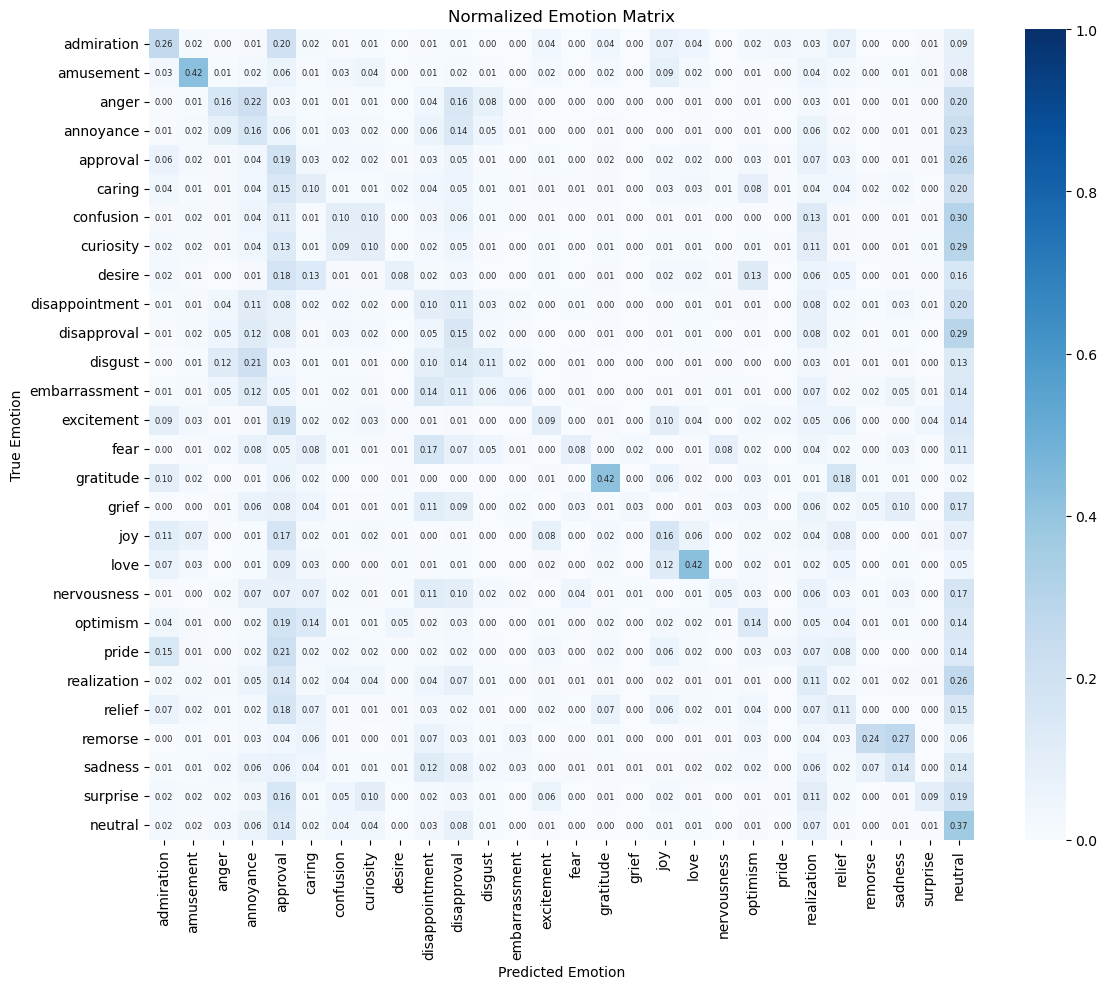

Hamming Loss: 0.07852154946485637
Subset Accuracy: 0.16217303822937626
Micro F1 Score: 0.33418400263803066
Macro F1 Score: 0.276926795004825


In [42]:
y_pred = transformer_multitask_model.predict(emotion_data['X_test'])[1]

y_pred_multilabel = np.zeros_like(y_pred)
for i, emo in enumerate(emotion_data['emotion_columns']):
    y_pred_multilabel[:, i] = (y_pred[:, i] >= optimal_thresholds_transformer[emo]).astype(int)
zero_rows = np.sum(y_pred_multilabel, axis=1) == 0
if np.any(zero_rows):
    max_indices = np.argmax(y_pred[zero_rows], axis=1)
    y_pred_multilabel[zero_rows, max_indices] = 1

y_true_multilabel = emotion_data['y_test']  

print("\nMulti-label Classification Report:")
print(classification_report(y_true_multilabel, y_pred_multilabel,
                          target_names=emotion_data['emotion_columns']))

emotion_co_occurrence = np.dot(y_true_multilabel.T, y_pred_multilabel)

row_sums = emotion_co_occurrence.sum(axis=1, keepdims=True)
row_sums = np.where(row_sums == 0, 1, row_sums)
emotion_co_occurrence_norm = emotion_co_occurrence / row_sums

plt.figure(figsize=(12, 10))
sns.heatmap(emotion_co_occurrence_norm, annot=True, fmt='.2f', cmap='Blues',
           xticklabels=emotion_data['emotion_columns'], 
           yticklabels=emotion_data['emotion_columns'],
           vmin=0, vmax=1,
           annot_kws={"size": 6}) 
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Normalized Emotion Matrix')
plt.tight_layout()
plt.show()


print(f"Hamming Loss: {hamming_loss(y_true_multilabel, y_pred_multilabel)}")
print(f"Subset Accuracy: {accuracy_score(y_true_multilabel, y_pred_multilabel)}")
print(f"Micro F1 Score: {f1_score(y_true_multilabel, y_pred_multilabel, average='micro')}")
print(f"Macro F1 Score: {f1_score(y_true_multilabel, y_pred_multilabel, average='macro')}")

In [43]:
# Save optimal thresholds to a JSON file
optimal_thresholds_transformer = {
    emotion: float(threshold) 
    for emotion, threshold in optimal_thresholds_transformer.items()
}

# Save optimal thresholds to JSON file
with open('optimal_thresholds_transformer.json', 'w') as f:
    json.dump(optimal_thresholds_transformer, f, indent=4)

### Ensemble Model

In [70]:
def create_ensemble_model(sentiment_model_path, emotion_model_path):

    sentiment_model = load_model(sentiment_model_path, compile=False)
    sentiment_model.name = 'sentiment_model'
    sentiment_model.trainable = False
    emotion_model = load_model(emotion_model_path, compile=False)
    emotion_model.name = 'emotion_model'
    emotion_model.trainable = False

    # Define new input layers
    sentiment_input = Input(shape=sentiment_model.input_shape[1:], name="sentiment_input")
    emotion_input = Input(shape=emotion_model.input_shape[1:], name="emotion_input")

    # Pass the inputs through the respective models
    sentiment_output = sentiment_model(sentiment_input)
    emotion_output = emotion_model(emotion_input)

    # Create the joint model
    joint_model = Model(
        inputs=[sentiment_input, emotion_input],
        outputs=[sentiment_output, emotion_output],
        name='ensemble_model'
    )

    return joint_model

def predict_ensemble_model(model, texts, tokenizer, max_length=500):
    # Tokenize and pad the input texts
    sequences = tokenizer.texts_to_sequences(texts)
    input = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Use the correct input layer names
    predictions = model.predict({
        'sentiment_input': input,  
        'emotion_input': input    
    })

    return {
        'sentiment': predictions[0],
        'emotion': predictions[1]
    }

In [71]:
joint_model = create_ensemble_model('models/CNN_sentiment_model_imdb&goemotions.keras', 'models/emotion_model.keras')

In [72]:
# Load the tokeniizer
with open('tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer = tokenizer_from_json(f.read())

In [73]:
predict_ensemble_model(joint_model, ["I love this movie!"], tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


{'sentiment': array([[0.9981094]], dtype=float32),
 'emotion': array([[1.0405763e-01, 4.7827363e-03, 2.4948121e-04, 2.3699652e-03,
         4.5165535e-02, 2.6850917e-03, 1.0858239e-03, 4.9849772e-03,
         3.4959035e-03, 3.0479133e-03, 1.0234334e-03, 3.6680006e-04,
         4.3058145e-04, 2.3560725e-02, 2.2187750e-04, 3.9157518e-03,
         1.1198490e-04, 4.5341510e-02, 7.6669407e-01, 4.9510716e-05,
         1.9895544e-03, 8.1008387e-04, 7.4343556e-03, 3.0005741e-04,
         8.4682455e-04, 6.5689245e-03, 5.8245170e-03, 1.9841317e-02]],
       dtype=float32)}

In [74]:
# Align the datasets to have the same number of samples
min_samples = min(len(sentiment_data['X_test']), len(emotion_data['X_test']))
sentiment_test_aligned = sentiment_data['X_test'][:min_samples]
emotion_test_aligned = emotion_data['X_test'][:min_samples]

# Now make predictions with aligned data
predictions = joint_model.predict([sentiment_test_aligned, emotion_test_aligned])

782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step


In [75]:
predictions

[array([[0.8559058 ],
        [0.9596846 ],
        [0.93095016],
        ...,
        [0.2028271 ],
        [0.514236  ],
        [0.77677214]], dtype=float32),
 array([[1.72935333e-03, 1.04525697e-03, 1.77118093e-01, ...,
         6.23182859e-03, 7.47916801e-03, 2.77029932e-01],
        [4.16495316e-02, 4.65548737e-03, 2.72492114e-02, ...,
         1.41960494e-02, 4.29921374e-02, 3.33885163e-01],
        [1.16075128e-02, 4.22085123e-03, 8.87550227e-03, ...,
         2.58452058e-01, 3.91958468e-02, 1.10027656e-01],
        ...,
        [9.36796796e-03, 2.32444913e-03, 5.16978838e-03, ...,
         1.42588268e-03, 1.45934559e-02, 5.93496442e-01],
        [5.46617031e-01, 2.38882843e-02, 5.31036407e-04, ...,
         1.10701134e-03, 3.68646383e-02, 8.48302841e-02],
        [1.65874546e-03, 9.88100842e-03, 1.11588776e-01, ...,
         1.27810732e-01, 1.10113695e-02, 1.47462025e-01]], dtype=float32)]

## Speech to text 

#### Load Audios and Transcribe Text

In [3]:
whisper_model = whisper.load_model("base")

In [4]:
# Load Audio Files Info
files_info = pd.read_excel("labels.xlsx")
files_info.head(10)

,filename,sentiment,emotion,text
0,audio10.m4a,positive,admiration,"After watching the performance, I couldn't hel..."
1,audio11.m4a,positive,admiration,I’m really impressed by the amount of work tha...
2,audio12.m4a,positive,admiration,That was truly amazing.
3,audio13.m4a,positive,admiration,Incredible!
4,audio14.m4a,positive,admiration,I had no idea the product would be this good. ...
5,audio15.m4a,positive,admiration,The way the show took such an enormous twist m...
6,audio125.m4a,positive,admiration,The way you handled that challenging situation...
7,audio157.m4a,positive,admiration,Your ability to remain calm under pressure is ...
8,audio185.m4a,positive,admiration,The level of detail in this painting is extrao...
9,audio16.m4a,positive,amusement,The movie was hilarious from start to finish. ...


In [5]:
len(files_info)

199

In [6]:
print("Available columns:", files_info.columns.tolist())

Available columns: ['filename', 'sentiment', 'emotion', 'text']


In [7]:
files_info['true_sentiment'] = [1 if i == 'positive' else 0 for i in files_info['sentiment']]

emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]
files_info['true_emotion'] = [np.array([1 if i == emotion else 0 for emotion in emotion_columns]) for i in files_info['emotion']]

files_info.head(10)

,filename,sentiment,emotion,text,true_sentiment,true_emotion
0,audio10.m4a,positive,admiration,"After watching the performance, I couldn't hel...",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,audio11.m4a,positive,admiration,I’m really impressed by the amount of work tha...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,audio12.m4a,positive,admiration,That was truly amazing.,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,audio13.m4a,positive,admiration,Incredible!,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,audio14.m4a,positive,admiration,I had no idea the product would be this good. ...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,audio15.m4a,positive,admiration,The way the show took such an enormous twist m...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,audio125.m4a,positive,admiration,The way you handled that challenging situation...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,audio157.m4a,positive,admiration,Your ability to remain calm under pressure is ...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,audio185.m4a,positive,admiration,The level of detail in this painting is extrao...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,audio16.m4a,positive,amusement,The movie was hilarious from start to finish. ...,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
# Transcribe audios to text
files_info['transcription'] = [whisper_model.transcribe(f"audio_files/{files_info['filename'][i]}")["text"] for i in range(len(files_info))]

c:\Users\35196\anaconda3\envs\UCP_APA_2425\lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [82]:
files_info.head(10)

,filename,sentiment,emotion,text,true_sentiment,true_emotion,transcription
0,audio10.m4a,positive,admiration,"After watching the performance, I couldn't hel...",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","After watching the performance, I couldn't he..."
1,audio11.m4a,positive,admiration,I’m really impressed by the amount of work tha...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",I'm really impressed by the amount of work th...
2,audio12.m4a,positive,admiration,That was truly amazing.,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",That was truly amazing.
3,audio13.m4a,positive,admiration,Incredible!,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Incredible.
4,audio14.m4a,positive,admiration,I had no idea the product would be this good. ...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",I had no idea the product would be this good....
5,audio15.m4a,positive,admiration,The way the show took such an enormous twist m...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The way the show took such an enormous twist ...
6,audio125.m4a,positive,admiration,The way you handled that challenging situation...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The way you handled that challenging situatio...
7,audio157.m4a,positive,admiration,Your ability to remain calm under pressure is ...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Your ability to remain calm and their pressur...
8,audio185.m4a,positive,admiration,The level of detail in this painting is extrao...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The level of detail in this painting is extra...
9,audio16.m4a,positive,amusement,The movie was hilarious from start to finish. ...,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","The movie was hilarious from start to finish,..."


In [11]:
# Define data preprocessing function
def data_preprocessing(text):

    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Load the tokeniizer
    with open('tokenizer.json', 'r', encoding='utf-8') as f:
        tokenizer = tokenizer_from_json(f.read())

    sequences = tokenizer.texts_to_sequences([text])
    encoded_text = pad_sequences(sequences, maxlen=500, padding='post')
    
    return encoded_text

#### Predictions 

In [84]:
with open('tokenizer.json', 'r', encoding='utf-8') as f:
        tokenizer = tokenizer_from_json(f.read())

In [85]:
processed_transcribed_texts = [data_preprocessing(files_info['transcription'][i]) for i in range(len(files_info['transcription']))]
processed_texts_array = np.vstack(processed_transcribed_texts)

processed_original_texts = [data_preprocessing(files_info['text'][i]) for i in range(len(files_info['text']))]
processed_texts_array_og = np.vstack(processed_original_texts)

In [86]:
# Predict on transcibed text
# Using Transformer model
predictions_transformer = transformer_multitask_model.predict(processed_texts_array)
# Using Ensemble model
predictions_ensemble = predict_ensemble_model(joint_model, files_info['transcription'], tokenizer)

# Predict on original text
# Using Transformer model
predictions_transformer_og = transformer_multitask_model.predict(processed_texts_array_og)
# Using Ensemble model
predictions_ensemble_og = predict_ensemble_model(joint_model, files_info['text'], tokenizer)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


In [87]:
# Predictiosn for sentiment
files_info['pred_sent_ensemble'] = [1 if i[0] >= 0.5 else 0 for i in predictions_ensemble['sentiment']]
predictions_transformer_sent = np.argmax(predictions_transformer[0], axis=1)
files_info['pred_sent_transformer'] = [1-i for i in predictions_transformer_sent]

files_info['pred_sent_ensemble_og'] = [1 if i[0] >= 0.5 else 0 for i in predictions_ensemble_og['sentiment']]
predictions_transformer_sent_og = np.argmax(predictions_transformer_og[0], axis=1)
files_info['pred_sent_transformer_og'] = [1-i for i in predictions_transformer_sent_og]

In [88]:
with open('optimal_thresholds.json') as f:
    optimal_thresholds = json.load(f)

with open('optimal_thresholds_transformer.json') as f:
    optimal_thresholds_transformer = json.load(f)

In [89]:
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

In [90]:
# Emotion predictions for transformer on transcribed text
pred_emo_transformer = np.zeros_like(predictions_transformer[1], dtype=int)
for i, emo in enumerate(emotion_columns):
    pred_emo_transformer[:, i] = (predictions_transformer[1][:, i] >= optimal_thresholds_transformer[emo]).astype(int)
# Check for rows with no emotions detected and set highest probability emotion to 1
zero_rows = np.sum(pred_emo_transformer, axis=1) == 0
if np.any(zero_rows):
    max_indices = np.argmax(predictions_transformer[1][zero_rows], axis=1)
    pred_emo_transformer[zero_rows, max_indices] = 1
files_info['pred_emo_transformer'] = [pred_emo_transformer[i] for i in range(len(pred_emo_transformer))]

In [91]:
# Emotion predictions for ensemble on transcribed text
pred_emo_ensemble = np.zeros_like(predictions_ensemble['emotion'], dtype=int)
for i, emo in enumerate(emotion_columns):
    pred_emo_ensemble[:, i] = (predictions_ensemble['emotion'][:, i] >= optimal_thresholds[emo]).astype(int)
# Check for rows with no emotions detected and set highest probability emotion to 1
zero_rows = np.sum(pred_emo_ensemble, axis=1) == 0
if np.any(zero_rows):
    max_indices = np.argmax(predictions_ensemble['emotion'][zero_rows], axis=1)
    pred_emo_ensemble[zero_rows, max_indices] = 1
files_info['pred_emo_ensemble'] = [pred_emo_ensemble[i] for i in range(len(pred_emo_ensemble))]

In [93]:
# Emotion predictions for transformer on original text
pred_emo_transformer_og = np.zeros_like(predictions_transformer_og[1], dtype=int)
for i, emo in enumerate(emotion_columns):
    pred_emo_transformer_og[:, i] = (predictions_transformer_og[1][:, i] >= optimal_thresholds_transformer[emo]).astype(int)
# Check for rows with no emotions detected and set highest probability emotion to 1
zero_rows = np.sum(pred_emo_transformer_og, axis=1) == 0
if np.any(zero_rows):
    max_indices = np.argmax(predictions_transformer_og[1][zero_rows], axis=1)
    pred_emo_transformer_og[zero_rows, max_indices] = 1
files_info['pred_emo_transformer_og'] = [pred_emo_transformer_og[i] for i in range(len(pred_emo_transformer_og))]

In [94]:
# Emotion predictions for ensemble on original text
pred_emo_ensemble_og = np.zeros_like(predictions_ensemble_og['emotion'], dtype=int)
for i, emo in enumerate(emotion_columns):
    pred_emo_ensemble_og[:, i] = (predictions_ensemble_og['emotion'][:, i] >= optimal_thresholds[emo]).astype(int)
# Check for rows with no emotions detected and set highest probability emotion to 1
zero_rows = np.sum(pred_emo_ensemble_og, axis=1) == 0
if np.any(zero_rows):
    max_indices = np.argmax(predictions_ensemble_og['emotion'][zero_rows], axis=1)
    pred_emo_ensemble_og[zero_rows, max_indices] = 1
files_info['pred_emo_ensemble_og'] = [pred_emo_ensemble_og[i] for i in range(len(pred_emo_ensemble_og))]

In [95]:
files_info.head(10)

,filename,sentiment,emotion,text,true_sentiment,true_emotion,transcription,pred_sent_ensemble,pred_sent_transformer,pred_sent_ensemble_og,pred_sent_transformer_og,pred_emo_transformer,pred_emo_ensemble,pred_emo_transformer_og,pred_emo_ensemble_og
0,audio10.m4a,positive,admiration,"After watching the performance, I couldn't hel...",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","After watching the performance, I couldn't he...",1,1,1,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,audio11.m4a,positive,admiration,I’m really impressed by the amount of work tha...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",I'm really impressed by the amount of work th...,1,0,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,audio12.m4a,positive,admiration,That was truly amazing.,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",That was truly amazing.,1,1,1,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,audio13.m4a,positive,admiration,Incredible!,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Incredible.,1,1,1,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,audio14.m4a,positive,admiration,I had no idea the product would be this good. ...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",I had no idea the product would be this good....,1,1,1,1,"[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
5,audio15.m4a,positive,admiration,The way the show took such an enormous twist m...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The way the show took such an enormous twist ...,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,audio125.m4a,positive,admiration,The way you handled that challenging situation...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The way you handled that challenging situatio...,1,1,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,audio157.m4a,positive,admiration,Your ability to remain calm under pressure is ...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Your ability to remain calm and their pressur...,1,1,1,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,audio185.m4a,positive,admiration,The level of detail in this painting is extrao...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The level of detail in this painting is extra...,1,1,0,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ..."
9,audio16.m4a,positive,amusement,The movie was hilarious from start to finish. ...,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","The movie was hilarious from start to finish,...",1,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..

#### Evaluation

In [96]:
acc_sent_ensemble = accuracy_score(files_info['true_sentiment'], files_info['pred_sent_ensemble'])
acc_sent_ensemble_og = accuracy_score(files_info['true_sentiment'], files_info['pred_sent_ensemble_og'])
acc_sent_transformer = accuracy_score(files_info['true_sentiment'], files_info['pred_sent_transformer'])
acc_sent_transformer_og = accuracy_score(files_info['true_sentiment'], files_info['pred_sent_transformer_og'])

In [98]:
print("Accuracy for sentiment task")
print(f"Ensemble model on transcribed text: {round(acc_sent_ensemble*100,2)}%")
print(f"Transformer model on transcribed text: {round(acc_sent_transformer*100,2)}%")
print(f"Ensemble model on original text: {round(acc_sent_ensemble_og*100,2)}%")
print(f"Transformer model on original text: {round(acc_sent_transformer_og*100,2)}%")

Accuracy for sentiment task
Ensemble model on transcribed text: 72.86%
Transformer model on transcribed text: 68.34%
Ensemble model on original text: 72.36%
Transformer model on original text: 67.34%


In [99]:
# AUC and F1 score for emotion task
y_true = np.array([i for i in files_info['true_emotion']])

In [100]:
# Ensemble model on transcribed text
auc_scores_ensemble = []
f1_scores_ensemble = []
y_pred = np.array([i for i in files_info['pred_emo_ensemble']])

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 1:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        auc_scores_ensemble.append(auc)

macro_auc_ensemble = np.mean(auc_scores_ensemble)

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 1:
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores_ensemble.append(f1)

macro_f1_ensemble = np.mean(f1_scores_ensemble)

In [102]:
# Ensemble model on original text
auc_scores_ensemble_og = []
f1_scores_ensemble_og = []
y_pred = np.array([i for i in files_info['pred_emo_ensemble_og']])

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 1:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        auc_scores_ensemble_og.append(auc)

macro_auc_ensemble_og = np.mean(auc_scores_ensemble_og)

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 0:
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores_ensemble_og.append(f1)

macro_f1_ensemble_og = np.mean(f1_scores_ensemble_og)

In [103]:
# Transformer model on transcribed text
auc_scores_transformer = []
f1_scores_transformer = []
y_pred = np.array([i for i in files_info['pred_emo_transformer']])

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 1:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        auc_scores_transformer.append(auc)

macro_auc_transformer = np.mean(auc_scores_transformer)

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 0:
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores_transformer.append(f1)

macro_f1_transformer = np.mean(f1_scores_transformer)

In [104]:
# Ensemble model on transcribed text
auc_scores_transformer_og = []
f1_scores_transformer_og = []
y_pred = np.array([i for i in files_info['pred_emo_transformer_og']])

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 1:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        auc_scores_transformer_og.append(auc)

macro_auc_transformer_og = np.mean(auc_scores_transformer_og)

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 0:
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores_transformer_og.append(f1)

macro_f1_transformer_og = np.mean(f1_scores_transformer_og)

In [105]:
print("Macro AUC for emotion task")
print(f"Ensemble model on transcribed text: {round(macro_auc_ensemble*100,2)}%")
print(f"Transformer model on transcribed text: {round(macro_auc_transformer*100,2)}%")
print(f"Ensemble model on original text: {round(macro_auc_ensemble_og*100,2)}%")
print(f"Transformer model on original text: {round(macro_auc_transformer_og*100,2)}%")

print("\nMacro F1 Score for emotion task")
print(f"Ensemble model on transcribed text: {round(macro_f1_ensemble*100,2)}%")
print(f"Transformer model on transcribed text: {round(macro_f1_transformer*100,2)}%")
print(f"Ensemble model on original text: {round(macro_f1_ensemble_og*100,2)}%")
print(f"Transformer model on original text: {round(macro_f1_transformer_og*100,2)}%")

Macro AUC for emotion task
Ensemble model on transcribed text: 60.26%
Transformer model on transcribed text: 57.01%
Ensemble model on original text: 61.35%
Transformer model on original text: 56.49%

Macro F1 Score for emotion task
Ensemble model on transcribed text: 20.39%
Transformer model on transcribed text: 17.26%
Ensemble model on original text: 21.41%
Transformer model on original text: 16.16%


## Finetune model to audio files

In [12]:
X = files_info['transcription'].values
sent_label = files_info['true_sentiment'].values
emo_label = np.stack(files_info['true_emotion'].values)

indices = np.arange(len(X))
X_train_idx, X_val_idx = train_test_split(indices, test_size=0.25, random_state=42)

processed_texts = [data_preprocessing(text) for text in X]
processed_texts_array = np.vstack(processed_texts)

X_train = processed_texts_array[X_train_idx]
X_val = processed_texts_array[X_val_idx]
sent_label_train = sent_label[X_train_idx]
sent_label_val = sent_label[X_val_idx]
sent_label_train_2 = np.array([(i, 1-i) for i in sent_label_train])
sent_label_val_2 = np.array([(i, 1-i) for i in sent_label_val])
emo_label_train = emo_label[X_train_idx].astype(np.float32)
emo_label_val = emo_label[X_val_idx].astype(np.float32)

#### Ensemble

In [148]:
sentiment_model = load_model('models/CNN_sentiment_model_imdb&goemotions.keras')
emotion_model = load_model("models/emotion_model.keras")

In [149]:
sentiment_model.fit(
    X_train, sent_label_train,
    batch_size=32,
    epochs=6,   
    validation_data=(X_val, sent_label_val),
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.6947 - loss: 0.5140 - val_accuracy: 0.7200 - val_loss: 0.5549
Epoch 2/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9266 - loss: 0.3141 - val_accuracy: 0.7400 - val_loss: 0.5430
Epoch 3/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9772 - loss: 0.1978 - val_accuracy: 0.7800 - val_loss: 0.5439
Epoch 4/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.1163 - val_accuracy: 0.7800 - val_loss: 0.5536


In [150]:
emotion_model.fit(
    X_train, emo_label_train,
    batch_size=32,
    epochs=6,
    validation_data=(X_val, emo_label_val),
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 561ms/step - auc: 0.6691 - f1_score: 0.0764 - loss: 0.1648 - val_auc: 0.6609 - val_f1_score: 0.0621 - val_loss: 0.1563
Epoch 2/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - auc: 0.7037 - f1_score: 0.0875 - loss: 0.1497 - val_auc: 0.6439 - val_f1_score: 0.0595 - val_loss: 0.1514
Epoch 3/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - auc: 0.7326 - f1_score: 0.0449 - loss: 0.1439 - val_auc: 0.6681 - val_f1_score: 0.0595 - val_loss: 0.1465
Epoch 4/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - auc: 0.7801 - f1_score: 0.0636 - loss: 0.1347 - val_auc: 0.6937 - val_f1_score: 0.0595 - val_loss: 0.1441
Epoch 5/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - auc: 0.8249 - f1_score: 0.0654 - loss: 0.1256 - val_auc: 0.6935 - val_f1_score: 0.0595 - val_loss: 0.1449
Epoch 6/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - auc: 0.8379 - f1_score: 0.0346 - loss: 0.1245 - val_auc: 0.6927 - val_f1_score: 0.0476 - val_loss: 0.1466


In [151]:
sentiment_model.save("models/sentiment_model_finetuned.keras")
emotion_model.save("models/emotion_model_finetuned.keras")

In [187]:
joint_model_finetuned = create_ensemble_model('models/sentiment_model_finetuned.keras', 'models/emotion_model_finetuned.keras')

In [188]:
predictions_ensemble_finetuned = predict_ensemble_model(joint_model_finetuned, files_info['transcription'], tokenizer)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


In [189]:
# Sentiment predictions for finetuned ensemble
files_info['pred_sent_ensemble_f'] = [1 if i[0] >= 0.5 else 0 for i in predictions_ensemble_finetuned['sentiment']]

# Emotion predictions for finetuned ensemble 
pred_emo_ensemble_f = np.zeros_like(predictions_ensemble_finetuned['emotion'], dtype=int)
for i, emo in enumerate(emotion_columns):
    pred_emo_ensemble_f[:, i] = (predictions_ensemble_finetuned['emotion'][:, i] >= optimal_thresholds[emo]).astype(int)
# Check for rows with no emotions detected and set highest probability emotion to 1
zero_rows = np.sum(pred_emo_ensemble_f, axis=1) == 0
if np.any(zero_rows):
    max_indices = np.argmax(predictions_ensemble_finetuned['emotion'][zero_rows], axis=1)
    pred_emo_ensemble_f[zero_rows, max_indices] = 1
files_info['pred_emo_ensemble_f'] = [pred_emo_ensemble_f[i] for i in range(len(pred_emo_ensemble_f))]

In [190]:
acc_sent_ensemble_f = accuracy_score(files_info['true_sentiment'], files_info['pred_sent_ensemble_f'])

auc_scores_ensemble_f = []
f1_scores_ensemble_f = []
y_true = np.array([i for i in files_info['true_emotion']])
y_pred = np.array([i for i in files_info['pred_emo_ensemble_f']])

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 1:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        auc_scores_ensemble_f.append(auc)

macro_auc_ensemble_f = np.mean(auc_scores_ensemble_f)

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 0:
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores_ensemble_f.append(f1)

macro_f1_ensemble_f = np.mean(f1_scores_ensemble_f)

In [191]:
print("Before finetuning")
print(f"Accuracy for sentiment: {round(acc_sent_ensemble*100,2)}%")
print(f"AUC for emotion: {round(macro_auc_ensemble*100,2)}%")
print(f"F1 Score for emotion: {round(macro_f1_ensemble*100,2)}%")

print("\nAfter finetuning")
print(f"Accuracy for sentiment: {round(acc_sent_ensemble_f*100,2)}%")
print(f"AUC for emotion: {round(macro_auc_ensemble_f*100,2)}%")
print(f"F1 Score for emotion: {round(macro_f1_ensemble_f*100,2)}%")

Before finetuning
Accuracy for sentiment: 72.86%
AUC for emotion: 60.26%
F1 Score for emotion: 20.39%

After finetuning
Accuracy for sentiment: 89.45%
AUC for emotion: 64.58%
F1 Score for emotion: 24.87%


#### Transformer

In [13]:
transformer_multitask_model.fit(
    X_train, {
        'sentiment_output': sent_label_train_2,
        'emotion_output': emo_label_train
    },
    batch_size=32,
    epochs=6,   
    validation_data=(X_val, 
                     {
                        'sentiment_output': sent_label_val_2,
                        'emotion_output': emo_label_val
                     }),
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 847ms/step - emotion_output_auc_9: 0.6597 - emotion_output_loss: 0.1758 - emotion_output_precision_9: 0.2261 - emotion_output_recall_9: 0.0563 - loss: 5.2356 - sentiment_output_accuracy: 0.7022 - sentiment_output_loss: 5.0096 - val_emotion_output_auc_9: 0.4931 - val_emotion_output_loss: 0.2944 - val_emotion_output_precision_9: 0.0000e+00 - val_emotion_output_recall_9: 0.0000e+00 - val_loss: 1.1288 - val_sentiment_output_accuracy: 0.7800 - val_sentiment_output_loss: 0.8947
Epoch 2/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - emotion_output_auc_9: 0.5536 - emotion_output_loss: 0.2689 - emotion_output_precision_9: 0.0000e+00 - emotion_output_recall_9: 0.0000e+00 - loss: 1.2525 - sentiment_output_accuracy: 0.7370 - sentiment_output_loss: 0.9895 - val_emotion_output_auc_9: 0.5000 - val_emotion_output_loss: 0.5295 - val_emotion_output_precision_9: 0.0000e+00 - val_emotion_output_recall_9: 0.0000e+00 - val_loss: 1.4451 - val_sentiment_output_accuracy: 0.760

In [14]:
# Predict again with transformer model
predictions_transformer_finetuned = transformer_multitask_model.predict(processed_texts_array)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


In [15]:
transformer_multitask_model.save("models/transformer_model_finetuned.keras")

In [159]:
# Sentiment predictions for finetuned transformer
predictions_transformer_sent_f = np.argmax(predictions_transformer_finetuned[0], axis=1)
files_info['pred_sent_transformer_f'] = [1-i for i in predictions_transformer_sent_f]

# Emotion predictions for finetuned transformer
pred_emo_transformer_f = np.zeros_like(predictions_transformer_finetuned[1])
for i, emo in enumerate(emotion_columns):
    pred_emo_transformer_f[:, i] = (predictions_transformer_finetuned[1][:, i] >= optimal_thresholds_transformer[emo]).astype(int)
# Check for rows with no emotions detected and set highest probability emotion to 1
zero_rows = np.sum(pred_emo_transformer_f, axis=1) == 0
if np.any(zero_rows):
    max_indices = np.argmax(predictions_transformer_finetuned[1][zero_rows], axis=1)
    pred_emo_transformer_f[zero_rows, max_indices] = 1
files_info['pred_emo_transformer_f'] = [pred_emo_transformer_f[i] for i in range(len(pred_emo_transformer_f))]

In [160]:
acc_sent_transformer_f = accuracy_score(files_info['true_sentiment'], files_info['pred_sent_transformer_f'])

auc_scores_transformer_f = []
f1_scores_transformer_f = []
y_pred = np.array([i for i in files_info['pred_emo_transformer_f']])

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 1:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        auc_scores_transformer_f.append(auc)

macro_auc_transformer_f = np.mean(auc_scores_transformer_f)

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 0:
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores_transformer_f.append(f1)

macro_f1_transformer_f = np.mean(f1_scores_transformer_f)

In [161]:
print("Before finetuning")
print(f"Accuracy for sentiment: {round(acc_sent_transformer*100,2)}%")
print(f"AUC for emotion: {round(macro_auc_transformer*100,2)}%")
print(f"F1 Score for emotion: {round(macro_f1_transformer*100,2)}%")

print("\nAfter finetuning")
print(f"Accuracy for sentiment: {round(acc_sent_transformer_f*100,2)}%")
print(f"AUC for emotion: {round(macro_auc_transformer_f*100,2)}%")
print(f"F1 Score for emotion: {round(macro_f1_transformer_f*100,2)}%")

Before finetuning
Accuracy for sentiment: 68.34%
AUC for emotion: 57.01%
F1 Score for emotion: 17.26%

After finetuning
Accuracy for sentiment: 73.37%
AUC for emotion: 52.14%
F1 Score for emotion: 5.01%


## LLM Comparison

In [164]:
from langchain_anthropic import ChatAnthropic
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
import asyncio

In [ ]:
ANTHROPIC_API_KEY = YOUR_API_KEY

In [166]:
# Claude setup
claude = ChatAnthropic(api_key=ANTHROPIC_API_KEY, model="claude-3-7-sonnet-20250219")
chat_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a sentiment analysis expert. Be concise and direct in your responses so your output is just the observed sentiment and primary emotion."),
    ("user", "Analyze the sentiment of the following text and classify it as positive or negative. Also identify the primary emotion expressed between the following emotions: 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring','confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'). Text: {text}")
])

chain = LLMChain(llm=claude, prompt=chat_prompt)

C:\Users\35196\AppData\Local\Temp\ipykernel_1444\49711181.py:8: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=claude, prompt=chat_prompt)


In [167]:
# Async function to process multiple texts
async def analyze_sentiments(texts):
    # Create tasks for each text
    tasks = [chain.arun(text=text) for text in texts]
    # Run tasks concurrently and get results
    results = await asyncio.gather(*tasks)
    return results

In [168]:
async def main():

    batch_size = 10
    total_rows = len(files_info)
    
    for i in range(0, total_rows, batch_size):
        batch = files_info['transcription'].iloc[i:i+batch_size].tolist()
        results = await analyze_sentiments(batch)
        
        # Add results to the dataframe
        files_info.loc[i:i+len(batch)-1, 'sentiment_analysis'] = results
        
        print(f"Processed {min(i+batch_size, total_rows)} of {total_rows} rows...")
        await asyncio.sleep(1)  # Add delay between batches
    
    # Save the updated dataframe
    files_info.to_csv('output_with_sentiment.csv', index=False)
    print("Analysis complete. Results saved to output_with_sentiment.csv")

# Run the async code
await main()

c:\Users\35196\anaconda3\envs\UCP_APA_2425\lib\asyncio\events.py:80: LangChainDeprecationWarning: The method `Chain.arun` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~ainvoke` instead.
  self._context.run(self._callback, *self._args)


Processed 10 of 199 rows...
Processed 20 of 199 rows...
Processed 30 of 199 rows...
Processed 40 of 199 rows...
Processed 50 of 199 rows...
Processed 60 of 199 rows...
Processed 70 of 199 rows...
Processed 80 of 199 rows...
Processed 90 of 199 rows...
Processed 100 of 199 rows...
Processed 110 of 199 rows...
Processed 120 of 199 rows...
Processed 130 of 199 rows...
Processed 140 of 199 rows...
Processed 150 of 199 rows...
Processed 160 of 199 rows...
Processed 170 of 199 rows...
Processed 180 of 199 rows...
Processed 190 of 199 rows...
Processed 199 of 199 rows...
Analysis complete. Results saved to output_with_sentiment.csv


In [169]:
files_info.head(10)

,filename,sentiment,emotion,text,true_sentiment,true_emotion,transcription,pred_sent_ensemble,pred_sent_transformer,pred_sent_ensemble_og,pred_sent_transformer_og,pred_emo_transformer,pred_emo_ensemble,pred_emo_transformer_og,pred_emo_ensemble_og,pred_sent_ensemble_f,pred_emo_ensemble_f,pred_sent_transformer_f,pred_emo_transformer_f,sentiment_analysis
0,audio10.m4a,positive,admiration,"After watching the performance, I couldn't hel...",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","After watching the performance, I couldn't he...",1,1,1,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Positive sentiment. Primary emotion: admiration.
1,audio11.m4a,positive,admiration,I’m really impressed by the amount of work tha...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",I'm really impressed by the amount of work th...,1,0,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",Positive sentiment. Primary emotion: admiration.
2,audio12.m4a,positive,admiration,That was truly amazing.,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",That was truly amazing.,1,1,1,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Positive sentiment. Primary emotion: admiration.
3,audio13.m4a,positive,admiration,Incredible!,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Incredible.,1,1,1,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Positive, admiration"
4,audio14.m4a,positive,admiration,I had no idea the product would be this good. ...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",I had no idea the product would be this good....,1,1,1,1,"[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Positive sentiment. Primary emotion: surprise.
5,audio15.m4a,positive,admiration,The way the show took such an enormous twist m...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The way the show took such an enormous twist ...,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Positive sentiment. Primary emotion: amusement.
6,audio125.m4a,positive,admiration,The way you handled that challenging situation...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The way you handled that challenging situatio...,1,1,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [170]:
def parse_claude_response(response):
    try:
        response = response.lower()
        
        sentiment = 1 if 'positive' in response else 0
        
        # Extract emotion by finding matches with emotion list
        found_emotion = 'neutral'  # default
        for emotion in emotion_columns:
            if emotion.lower() in response:
                found_emotion = emotion
                break
                
        return sentiment, found_emotion
    except:
        return None, None

In [171]:
sentiments = []
emotions = []

for result in files_info['sentiment_analysis']:
    sent, emo = parse_claude_response(result)
    sentiments.append(sent)
    # Create one-hot encoding for emotions
    emotion_array = np.array([1 if emo == emotion else 0 for emotion in emotion_columns])
    emotions.append(emotion_array)

# Convert emotions list to numpy array for proper assignment
emotions = np.array(emotions)

# Use .loc to properly set values
files_info.loc[:, 'claude_sentiment'] = sentiments
files_info.loc[:, 'claude_emotion'] = [arr for arr in emotions]

In [172]:
acc_sent_llm = accuracy_score(files_info['true_sentiment'], files_info['claude_sentiment'])

# AUC and F1 score for emotion task
y_true = np.array([i for i in files_info['true_emotion']])

auc_scores_llm = []
f1_scores_llm = []
y_pred = np.array([i for i in files_info['claude_emotion']])

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 1:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        auc_scores_llm.append(auc)

macro_auc_llm = np.mean(auc_scores_llm)

for i in range(len(emotion_columns)):
    if len(np.unique(y_true[:, i])) > 0:
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores_llm.append(f1)

macro_f1_llm = np.mean(f1_scores_llm)

c:\Users\35196\anaconda3\envs\UCP_APA_2425\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [173]:
print("\nClaude Performance:")
print(f"Accuracy for sentiment: {round(acc_sent_llm*100,2)}%")
print(f"AUC for emotion: {round(macro_auc_llm*100,2)}%")
print(f"F1 Score for emotion: {round(macro_f1_llm*100,2)}%")


Claude Performance:
Accuracy for sentiment: 96.98%
AUC for emotion: 85.41%
F1 Score for emotion: 68.34%


## Models Comparison and Evaluation

In [203]:
files_info.to_csv('output_with_sentiment.csv', index=False)
#files_info = pd.read_csv('output_with_sentiment.csv')

In [174]:
# Join all accuracy and performance metrics on a dataframe

performance_df = pd.DataFrame({
    'Model': ['Transformer (Transcribed Text)', 
              'Transformer (Original Text)',
              'Ensemble (Transcribed Text)', 
              'Ensemble (Original Text)',
              'Finetuned Transformer (Transcribed Text)', 
              'Finetuned Ensemble (Transcribed Text)',
              'Claude (Transcribed Text)'
              ],
    'Sentiment Accuracy (%)': [
        round(acc_sent_transformer*100, 2),
        round(acc_sent_transformer_og*100, 2),
        round(acc_sent_ensemble*100, 2),
        round(acc_sent_ensemble_og*100, 2),
        round(acc_sent_transformer_f*100, 2),
        round(acc_sent_ensemble_f*100, 2),
        round(acc_sent_llm*100, 2)
    ],
    'Emotion AUC (%)': [
        round(macro_auc_transformer*100, 2),
        round(macro_auc_transformer_og*100, 2),
        round(macro_auc_ensemble*100, 2),
        round(macro_auc_ensemble_og*100, 2),
        round(macro_auc_transformer_f*100, 2),
        round(macro_auc_ensemble_f*100, 2),
        round(macro_auc_llm*100, 2)
    ],
    'Emotion F1 Score (%)': [
        round(macro_f1_transformer*100, 2),
        round(macro_f1_transformer_og*100, 2),
        round(macro_f1_ensemble*100, 2),
        round(macro_f1_ensemble_og*100, 2),
        round(macro_f1_transformer_f*100, 2),
        round(macro_f1_ensemble_f*100, 2),
        round(macro_f1_llm*100, 2)
    ]
})

In [175]:
performance_df

,Model,Sentiment Accuracy (%),Emotion AUC (%),Emotion F1 Score (%)
0,Transformer (Transcribed Text),68.34,57.01,17.26
1,Transformer (Original Text),67.34,56.49,16.16
2,Ensemble (Transcribed Text),72.86,60.26,20.39
3,Ensemble (Original Text),72.36,61.35,21.41
4,Finetuned Transformer (Transcribed Text),73.37,52.14,5.01
5,Finetuned Ensemble (Transcribed Text),89.45,64.58,24.87
6,Claude (Transcribed Text),96.98,85.41,68.34


In [194]:
emotions = emotion_columns[:-1]  
models = [
    'Transformer (Transcribed Text)',
    'Transformer (Original Text)',
    'Ensemble (Transcribed Text)',
    'Ensemble (Original Text)',
    'Finetuned Transformer (Transcribed Text)',
    'Finetuned Ensemble (Transcribed Text)',
    'Claude (Transcribed Text)'
]

# Create column MultiIndex
column_tuples = [(model, metric) for model in models for metric in ['AUC', 'F1 Score']]
column_index = pd.MultiIndex.from_tuples(column_tuples, names=['Model', 'Metric'])

# Initialize DataFrame with appropriate shape
performance_per_emotion = pd.DataFrame(
    index=emotions,
    columns=column_index
)

# Fill in the values
for i, emotion in enumerate(emotions):
    performance_per_emotion.loc[emotion, ('Transformer (Transcribed Text)', 'AUC')] = round(auc_scores_transformer[i], 2)
    performance_per_emotion.loc[emotion, ('Transformer (Transcribed Text)', 'F1 Score')] = round(f1_scores_transformer[i], 2)
    
    performance_per_emotion.loc[emotion, ('Transformer (Original Text)', 'AUC')] = round(auc_scores_transformer_og[i], 2)
    performance_per_emotion.loc[emotion, ('Transformer (Original Text)', 'F1 Score')] = round(f1_scores_transformer_og[i], 2)
    
    performance_per_emotion.loc[emotion, ('Ensemble (Transcribed Text)', 'AUC')] = round(auc_scores_ensemble[i], 2)
    performance_per_emotion.loc[emotion, ('Ensemble (Transcribed Text)', 'F1 Score')] = round(f1_scores_ensemble[i], 2)
    
    performance_per_emotion.loc[emotion, ('Ensemble (Original Text)', 'AUC')] = round(auc_scores_ensemble_og[i], 2)
    performance_per_emotion.loc[emotion, ('Ensemble (Original Text)', 'F1 Score')] = round(f1_scores_ensemble_og[i], 2)
    
    performance_per_emotion.loc[emotion, ('Finetuned Transformer (Transcribed Text)', 'AUC')] = round(auc_scores_transformer_f[i], 2)
    performance_per_emotion.loc[emotion, ('Finetuned Transformer (Transcribed Text)', 'F1 Score')] = round(f1_scores_transformer_f[i], 2)

    performance_per_emotion.loc[emotion, ('Finetuned Ensemble (Transcribed Text)', 'AUC')] = round(auc_scores_ensemble_f[i], 2)
    performance_per_emotion.loc[emotion, ('Finetuned Ensemble (Transcribed Text)', 'F1 Score')] = round(f1_scores_ensemble_f[i], 2)
    
    performance_per_emotion.loc[emotion, ('Claude (Transcribed Text)', 'AUC')] = round(auc_scores_llm[i], 2)
    performance_per_emotion.loc[emotion, ('Claude (Transcribed Text)', 'F1 Score')] = round(f1_scores_llm[i], 2)

In [196]:
performance_per_emotion

Model          Transformer (Transcribed Text)          Transformer (Original Text)          Ensemble (Transcribed Text)          Ensemble (Original Text)          Finetuned Transformer (Transcribed Text)          Finetuned Ensemble (Transcribed Text)          Claude (Transcribed Text)         
Metric                                    AUC F1 Score                         AUC F1 Score                         AUC F1 Score                      AUC F1 Score                                      AUC F1 Score                                   AUC F1 Score                       AUC F1 Score
admiration                               0.62     0.19                        0.61     0.18                        0.69      0.3                     0.74     0.34                                     0.65     0.32                                  0.76     0.45                      0.88      0.7
amusement                                0.78     0.62                        0.78     0.62                        0.78     0.57                     0.78     0.57                                      0.5      0.0                                  0.78     0.62                      0.85     0.77
anger                                     0.6     0.24                         0.6     0.25                        0.59     0.22                     0.59     0.22                                     0.66     0.38                                   0.6     0.25                      0.55     0.17
annoyance                                0.64      0.3                        0.63     0.26                        0.71     0.38                     0.72     0.39                                     0.48      0.0                                  0.78     0.31                      0.78     0.61
approval                                 0.38     0.04                        0.38     0.04                        0.54      0.1                      0.5     0.08                                      0.5      0.0                                  0.66     0.22                      0.87     0.61
caring                                   0.46      0.0                        0.47      0.0                        0.44      0.0                     0.46      0.0                                     0.52     0.06                                   0.6     0.12                      0.67      0.5
confusion                                0.52     0.08                        0.53      0.1                        0.71      0.3                      0.7     0.25                                      0.5      0.0                                  0.68     0.46                      0.94     0.93
curiosity                                0.67     0.32                        0.67     0.33                        0.61     0.14                     0.61     0.15                                      0.5      0.0                                   0.5      0.0                       1.0      1.0
desire                                   0.49      0.0                        0.49      0.0                        0.58     0.14                     0.58     0.17                                      0.5      0.0                                  0.59     0.18                       0.6     0.33
disappointment                           0.53      0.1                        0.58     0.17                        0.46      0.0                     0.52     0.08                                      0.5      0.0                                   0.5      0.0                      0.94     0.46
disapproval                              0.51     0.06                         0.5     0.06                        0.65     0.18                     0.72     0.21                                      0.5      0.0                                   0.6     0.17                       0.5      0.0
disgust                                  0.54     0.12                        0.48      0.0                        0.48      0.0                     0.48      0.0   

In [201]:
print("\nTop 3 performing emotions for each model-metric combination:")
for model in models[:-1]:
    print(f"\n{model}:")
    
    # For AUC - sort values in descending order and get top 3
    top3_auc = performance_per_emotion.loc[emotions, (model, 'AUC')].sort_values(ascending=False).head(3)
    print(f"  - AUC Top 3:")
    for emotion, score in top3_auc.items():
        print(f"    {emotion}: {score:.3f}")
    
    # For F1 Score - sort values in descending order and get top 3
    top3_f1 = performance_per_emotion.loc[emotions, (model, 'F1 Score')].sort_values(ascending=False).head(3)
    print(f"  - F1 Score Top 3:")
    for emotion, score in top3_f1.items():
        print(f"    {emotion}: {score:.3f}")


Top 3 performing emotions for each model-metric combination:

Transformer (Transcribed Text):
  - AUC Top 3:
    amusement: 0.780
    love: 0.740
    optimism: 0.720
  - F1 Score Top 3:
    amusement: 0.620
    love: 0.500
    gratitude: 0.400

Transformer (Original Text):
  - AUC Top 3:
    amusement: 0.780
    love: 0.740
    optimism: 0.720
  - F1 Score Top 3:
    amusement: 0.620
    love: 0.500
    gratitude: 0.400

Ensemble (Transcribed Text):
  - AUC Top 3:
    optimism: 0.860
    amusement: 0.780
    love: 0.740
  - F1 Score Top 3:
    amusement: 0.570
    optimism: 0.550
    love: 0.550

Ensemble (Original Text):
  - AUC Top 3:
    optimism: 0.860
    amusement: 0.780
    admiration: 0.740
  - F1 Score Top 3:
    amusement: 0.570
    optimism: 0.550
    love: 0.500

Finetuned Transformer (Transcribed Text):
  - AUC Top 3:
    anger: 0.660
    admiration: 0.650
    gratitude: 0.640
  - F1 Score Top 3:
    anger: 0.380
    gratitude: 0.330
    admiration: 0.320

Finetuned Ensem

In [202]:
print("\nBottom 3 performing emotions for each model-metric combination:")
for model in models[:-1]:
    print(f"\n{model}:")
    
    # For AUC - sort values in ascending order and get top 3
    top3_auc = performance_per_emotion.loc[emotions, (model, 'AUC')].sort_values(ascending=True).head(3)
    print(f"  - AUC Top 3:")
    for emotion, score in top3_auc.items():
        print(f"    {emotion}: {score:.3f}")
    
    # For F1 Score - sort values in ascending order and get top 3
    top3_f1 = performance_per_emotion.loc[emotions, (model, 'F1 Score')].sort_values(ascending=True).head(3)
    print(f"  - F1 Score Top 3:")
    for emotion, score in top3_f1.items():
        print(f"    {emotion}: {score:.3f}")


Bottom 3 performing emotions for each model-metric combination:

Transformer (Transcribed Text):
  - AUC Top 3:
    approval: 0.380
    caring: 0.460
    excitement: 0.490
  - F1 Score Top 3:
    excitement: 0.000
    nervousness: 0.000
    grief: 0.000

Transformer (Original Text):
  - AUC Top 3:
    approval: 0.380
    caring: 0.470
    excitement: 0.480
  - F1 Score Top 3:
    excitement: 0.000
    nervousness: 0.000
    grief: 0.000

Ensemble (Transcribed Text):
  - AUC Top 3:
    caring: 0.440
    disappointment: 0.460
    disgust: 0.480
  - F1 Score Top 3:
    grief: 0.000
    remorse: 0.000
    fear: 0.000

Ensemble (Original Text):
  - AUC Top 3:
    caring: 0.460
    pride: 0.480
    disgust: 0.480
  - F1 Score Top 3:
    grief: 0.000
    remorse: 0.000
    pride: 0.000

Finetuned Transformer (Transcribed Text):
  - AUC Top 3:
    annoyance: 0.480
    love: 0.490
    sadness: 0.490
  - F1 Score Top 3:
    excitement: 0.000
    remorse: 0.000
    relief: 0.000

Finetuned Ensem